### Cab-Driver Agent

In [15]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [16]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [17]:
Time_matrix[1,2,:,5]

array([ 9.,  9.,  9.,  9.,  9.,  9., 11., 11., 11., 11., 11., 11.,  2.,
        2.,  2.,  2.,  2.,  2.,  6.,  6.,  6.,  6.,  6.,  6.])

#### Tracking the state-action pairs for checking convergence


In [18]:
States_track = collections.defaultdict(dict)
print(len(States_track))

0


In [19]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [((0, 0, 0), (0,1)), ((0, 0, 0), (0,2))]    
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = [] 

In [20]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [25]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor =0.95
        self.learning_rate =0.001        
        self.epsilon_max =1 
        self.epsilon =1 
        self.epsilon_decay =0.001 
        self.epsilon_min = 0.00001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets   
        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, action_space, possible_actions_index):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # in case of cartpole this will randomly choose an action between 0 and 1
            index = random.randrange(len(possible_actions_index))
            action_index = possible_actions_index[index]
            action = action_space[action_index]
            return action_index, action

        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size

            state = np.array(state).reshape(1, self.state_size)
            q_value = self.model.predict(state)
            #print("action picked from compile model = {}".format(q_value))

            return np.argmax(q_value[0]), action_space[np.argmax(q_value[0])]

    def append_sample(self, state, action, reward, next_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state))

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        # print("trying training model")
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)

            update_output = np.zeros((self.batch_size, self.state_size))  # write here
            update_input = np.zeros((self.batch_size, self.state_size))  # write here

            actions, rewards = [], []

            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state

                # Write your code from here
                # 1. Predict the target from earlier model
                target = self.model.predict(update_input)

                # 2. Get the target for the Q-network
                target_qval = self.model.predict(update_output)

                # 3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                ### do we need to handle terminal state. termination function here is independent
                #  from actions and state so we can ignore it

                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    def store_q_values(self):
        """ We are keeping track of q value for state [0,0,0] and action (0,2)"""
        q_value = self.model.predict(self.track_state)
        self.states_tracked.append(q_value[0][2])
            
    def save(self, name):
        self.model.save(name)
    

In [26]:
Episodes = 20000

### DQN block

In [27]:
start_time = time.time()
rewards_per_episode, episodes, avg_rewards_per_episode = [], [], []

env = CabDriver()
agent = DQNAgent(action_size=len(env.action_space), state_size=len(env.state_encod_arch1(
    env.state_init)))

for episode in range(Episodes):

    # Write code here
    # Call the environment
    env = CabDriver()
    score = 0
    # Call all the initialised variables of the environment
    action_space, state_space, state = env.reset()

    terminal_state = False
    t = 0
    count = 1
    while not terminal_state:
        #print("count = {}".format(count))
        count += 1
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        possible_actions_index, actions = env.requests(state)
        action_index, action = agent.get_action(env.state_encod_arch1(state), env.action_space, possible_actions_index)
        # 2. Evaluate your reward and next state
        next_state, wait_time, transit_time, ride_time = env.next_state_func(state, action,
                                                                             Time_matrix)
        reward = env.reward_func(state, action, Time_matrix)
        # 3. Append the experience to the memory
        agent.append_sample(env.state_encod_arch1(state), action_index,
                            reward, env.state_encod_arch1(next_state))
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        # 5. Keep a track of rewards, Q-values, loss
        score += reward
        state = next_state
        t += wait_time + transit_time + ride_time
        #print(t)
        # TODO Do we need a logic to make sure that total time never goes more than 30 days. Which
        # TODO requires last ride to be less than the time left
        # TODO OR we not very hard strict with 30 days, driver can even work extra few hour just
        # TODO because of last ride
        if t >= 24 * 30:
            print("state terminated")
            terminal_state = True

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # epsilon decay
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(-agent.epsilon_decay*episode)

    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,
                                                                           score,
                                                                           len(agent.memory),
                                                                           agent.epsilon))
    # every few episodes:
    if episode % 10 == 0:
        # store q-values of some prespecified state-action pairs
        agent.store_q_values()
    if episode % 1000 == 0:
        agent.save(name="model.pkl")
        elapsed_time = time.time() - start_time
        print('Total time taken ',elapsed_time)
### TODO Keep a track of Q-values, loss

state terminated
episode 0, reward -97.0, memory_length 137, epsilon 1.0
Total time taken  14.124994039535522
state terminated
episode 1, reward -297.0, memory_length 272, epsilon 0.9990005098283767
state terminated
episode 2, reward -79.0, memory_length 414, epsilon 0.9980020186473464
state terminated
episode 3, reward -216.0, memory_length 574, epsilon 0.997004525458418
state terminated
episode 4, reward 174.0, memory_length 726, epsilon 0.996008029264098
state terminated
episode 5, reward -457.0, memory_length 874, epsilon 0.9950125290678904
state terminated
episode 6, reward -752.0, memory_length 1028, epsilon 0.9940180238742947
state terminated
episode 7, reward -228.0, memory_length 1194, epsilon 0.9930245126888058
state terminated
episode 8, reward -390.0, memory_length 1352, epsilon 0.9920319945179122
state terminated
episode 9, reward -284.0, memory_length 1483, epsilon 0.9910404683690959
state terminated
episode 10, reward -131.0, memory_length 1636, epsilon 0.990049933250830

state terminated
episode 91, reward 39.0, memory_length 2000, epsilon 0.9130185807221568
state terminated
episode 92, reward -28.0, memory_length 2000, epsilon 0.9121060284935949
state terminated
episode 93, reward 26.0, memory_length 2000, epsilon 0.9111943883611375
state terminated
episode 94, reward 229.0, memory_length 2000, epsilon 0.9102836594131446
state terminated
episode 95, reward 50.0, memory_length 2000, epsilon 0.9093738407388867
state terminated
episode 96, reward 57.0, memory_length 2000, epsilon 0.9084649314285455
state terminated
episode 97, reward 162.0, memory_length 2000, epsilon 0.9075569305732114
state terminated
episode 98, reward -123.0, memory_length 2000, epsilon 0.9066498372648834
state terminated
episode 99, reward -15.0, memory_length 2000, epsilon 0.9057436505964682
state terminated
episode 100, reward 289.0, memory_length 2000, epsilon 0.9048383696617791
state terminated
episode 101, reward -73.0, memory_length 2000, epsilon 0.9039339935555353
state termi

state terminated
episode 182, reward 294.0, memory_length 2000, epsilon 0.8336030044023311
state terminated
episode 183, reward 492.0, memory_length 2000, epsilon 0.8327698280555336
state terminated
episode 184, reward 204.0, memory_length 2000, epsilon 0.8319374844686335
state terminated
episode 185, reward 431.0, memory_length 2000, epsilon 0.8311059728092871
state terminated
episode 186, reward 318.0, memory_length 2000, epsilon 0.8302752922459828
state terminated
episode 187, reward 287.0, memory_length 2000, epsilon 0.82944544194804
state terminated
episode 188, reward 307.0, memory_length 2000, epsilon 0.8286164210856083
state terminated
episode 189, reward 443.0, memory_length 2000, epsilon 0.8277882288296666
state terminated
episode 190, reward 224.0, memory_length 2000, epsilon 0.8269608643520229
state terminated
episode 191, reward 290.0, memory_length 2000, epsilon 0.8261343268253123
state terminated
episode 192, reward 223.0, memory_length 2000, epsilon 0.8253086154229974
s

state terminated
episode 273, reward 481.0, memory_length 2000, epsilon 0.761095176701058
state terminated
episode 274, reward 368.0, memory_length 2000, epsilon 0.7603344719401295
state terminated
episode 275, reward 354.0, memory_length 2000, epsilon 0.7595745275037362
state terminated
episode 276, reward 251.0, memory_length 2000, epsilon 0.7588153426319337
state terminated
episode 277, reward 619.0, memory_length 2000, epsilon 0.7580569165655372
state terminated
episode 278, reward 203.0, memory_length 2000, epsilon 0.7572992485461204
state terminated
episode 279, reward 445.0, memory_length 2000, epsilon 0.7565423378160152
state terminated
episode 280, reward 559.0, memory_length 2000, epsilon 0.7557861836183108
state terminated
episode 281, reward 350.0, memory_length 2000, epsilon 0.7550307851968532
state terminated
episode 282, reward 486.0, memory_length 2000, epsilon 0.7542761417962436
state terminated
episode 283, reward 558.0, memory_length 2000, epsilon 0.7535222526618386


state terminated
episode 364, reward 549.0, memory_length 2000, epsilon 0.6948942458309632
state terminated
episode 365, reward 792.0, memory_length 2000, epsilon 0.6941997089114701
state terminated
episode 366, reward 882.0, memory_length 2000, epsilon 0.6935058661817437
state terminated
episode 367, reward 655.0, memory_length 2000, epsilon 0.6928127169479412
state terminated
episode 368, reward 849.0, memory_length 2000, epsilon 0.6921202605169134
state terminated
episode 369, reward 920.0, memory_length 2000, epsilon 0.691428496196204
state terminated
episode 370, reward 757.0, memory_length 2000, epsilon 0.6907374232940483
state terminated
episode 371, reward 556.0, memory_length 2000, epsilon 0.6900470411193734
state terminated
episode 372, reward 486.0, memory_length 2000, epsilon 0.6893573489817971
state terminated
episode 373, reward 760.0, memory_length 2000, epsilon 0.6886683461916273
state terminated
episode 374, reward 890.0, memory_length 2000, epsilon 0.6879800320598611


state terminated
episode 454, reward 918.0, memory_length 2000, epsilon 0.6350863824185956
state terminated
episode 455, reward 1140.0, memory_length 2000, epsilon 0.6344516234685488
state terminated
episode 456, reward 1250.0, memory_length 2000, epsilon 0.633817498960178
state terminated
episode 457, reward 818.0, memory_length 2000, epsilon 0.6331840082593592
state terminated
episode 458, reward 1052.0, memory_length 2000, epsilon 0.6325511507326013
state terminated
episode 459, reward 891.0, memory_length 2000, epsilon 0.6319189257470469
state terminated
episode 460, reward 1241.0, memory_length 2000, epsilon 0.6312873326704709
state terminated
episode 461, reward 1005.0, memory_length 2000, epsilon 0.6306563708712802
state terminated
episode 462, reward 1193.0, memory_length 2000, epsilon 0.6300260397185128
state terminated
episode 463, reward 1023.0, memory_length 2000, epsilon 0.6293963385818379
state terminated
episode 464, reward 512.0, memory_length 2000, epsilon 0.6287672668

state terminated
episode 544, reward 1260.0, memory_length 2000, epsilon 0.5804261109215909
state terminated
episode 545, reward 792.0, memory_length 2000, epsilon 0.579845984922013
state terminated
episode 546, reward 1162.0, memory_length 2000, epsilon 0.5792664387584682
state terminated
episode 547, reward 891.0, memory_length 2000, epsilon 0.5786874718514106
state terminated
episode 548, reward 864.0, memory_length 2000, epsilon 0.5781090836218729
state terminated
episode 549, reward 908.0, memory_length 2000, epsilon 0.577531273491467
state terminated
episode 550, reward 971.0, memory_length 2000, epsilon 0.5769540408823828
state terminated
episode 551, reward 844.0, memory_length 2000, epsilon 0.5763773852173877
state terminated
episode 552, reward 824.0, memory_length 2000, epsilon 0.5758013059198256
state terminated
episode 553, reward 1350.0, memory_length 2000, epsilon 0.5752258024136175
state terminated
episode 554, reward 1187.0, memory_length 2000, epsilon 0.57465087412325

state terminated
episode 634, reward 1608.0, memory_length 2000, epsilon 0.5304703842050862
state terminated
episode 635, reward 1201.0, memory_length 2000, epsilon 0.5299401889626854
state terminated
episode 636, reward 1538.0, memory_length 2000, epsilon 0.5294105236505174
state terminated
episode 637, reward 1092.0, memory_length 2000, epsilon 0.5288813877389174
state terminated
episode 638, reward 1036.0, memory_length 2000, epsilon 0.5283527806987491
state terminated
episode 639, reward 858.0, memory_length 2000, epsilon 0.5278247020014056
state terminated
episode 640, reward 1082.0, memory_length 2000, epsilon 0.5272971511188081
state terminated
episode 641, reward 1026.0, memory_length 2000, epsilon 0.5267701275234057
state terminated
episode 642, reward 1032.0, memory_length 2000, epsilon 0.5262436306881746
state terminated
episode 643, reward 958.0, memory_length 2000, epsilon 0.5257176600866181
state terminated
episode 644, reward 1398.0, memory_length 2000, epsilon 0.5251922

state terminated
episode 724, reward 1902.0, memory_length 2000, epsilon 0.4848142876759856
state terminated
episode 725, reward 1351.0, memory_length 2000, epsilon 0.4843297257096729
state terminated
episode 726, reward 1385.0, memory_length 2000, epsilon 0.48384564806312635
state terminated
episode 727, reward 1233.0, memory_length 2000, epsilon 0.48336205425226814
state terminated
episode 728, reward 1264.0, memory_length 2000, epsilon 0.4828789437935045
state terminated
episode 729, reward 1365.0, memory_length 2000, epsilon 0.4823963162037248
state terminated
episode 730, reward 1322.0, memory_length 2000, epsilon 0.4819141710003016
state terminated
episode 731, reward 1296.0, memory_length 2000, epsilon 0.4814325077010895
state terminated
episode 732, reward 1248.0, memory_length 2000, epsilon 0.4809513258244252
state terminated
episode 733, reward 1682.0, memory_length 2000, epsilon 0.48047062488912684
state terminated
episode 734, reward 1476.0, memory_length 2000, epsilon 0.47

state terminated
episode 813, reward 1480.0, memory_length 2000, epsilon 0.4435310566302907
state terminated
episode 814, reward 1721.0, memory_length 2000, epsilon 0.443087757260287
state terminated
episode 815, reward 1432.0, memory_length 2000, epsilon 0.4426449009680775
state terminated
episode 816, reward 1673.0, memory_length 2000, epsilon 0.44220248731080586
state terminated
episode 817, reward 1176.0, memory_length 2000, epsilon 0.44176051584605835
state terminated
episode 818, reward 1361.0, memory_length 2000, epsilon 0.44131898613186354
state terminated
episode 819, reward 1475.0, memory_length 2000, epsilon 0.44087789772669167
state terminated
episode 820, reward 1718.0, memory_length 2000, epsilon 0.44043725018945423
state terminated
episode 821, reward 1521.0, memory_length 2000, epsilon 0.43999704307950366
state terminated
episode 822, reward 1369.0, memory_length 2000, epsilon 0.43955727595663285
state terminated
episode 823, reward 1488.0, memory_length 2000, epsilon 0

state terminated
episode 902, reward 1503.0, memory_length 2000, epsilon 0.4057632754452853
state terminated
episode 903, reward 1530.0, memory_length 2000, epsilon 0.40535772497886907
state terminated
episode 904, reward 1390.0, memory_length 2000, epsilon 0.40495257986021166
state terminated
episode 905, reward 1509.0, memory_length 2000, epsilon 0.4045478396841678
state terminated
episode 906, reward 1682.0, memory_length 2000, epsilon 0.40414350404599736
state terminated
episode 907, reward 1224.0, memory_length 2000, epsilon 0.4037395725413646
state terminated
episode 908, reward 1561.0, memory_length 2000, epsilon 0.4033360447663381
state terminated
episode 909, reward 1671.0, memory_length 2000, epsilon 0.4029329203173899
state terminated
episode 910, reward 1401.0, memory_length 2000, epsilon 0.4025301987913957
state terminated
episode 911, reward 1433.0, memory_length 2000, epsilon 0.4021278797856337
state terminated
episode 912, reward 1222.0, memory_length 2000, epsilon 0.40

state terminated
episode 991, reward 1608.0, memory_length 2000, epsilon 0.37121158800445464
state terminated
episode 992, reward 2002.0, memory_length 2000, epsilon 0.3708405719553927
state terminated
episode 993, reward 1608.0, memory_length 2000, epsilon 0.37046992673693363
state terminated
episode 994, reward 1581.0, memory_length 2000, epsilon 0.3700996519784322
state terminated
episode 995, reward 1426.0, memory_length 2000, epsilon 0.36972974730961355
state terminated
episode 996, reward 1426.0, memory_length 2000, epsilon 0.36936021236057304
state terminated
episode 997, reward 1482.0, memory_length 2000, epsilon 0.3689910467617757
state terminated
episode 998, reward 1353.0, memory_length 2000, epsilon 0.3686222501440558
state terminated
episode 999, reward 1575.0, memory_length 2000, epsilon 0.3682538221386168
state terminated
episode 1000, reward 1778.0, memory_length 2000, epsilon 0.36788576237703063
Total time taken  11743.926418542862
state terminated
episode 1001, reward

state terminated
episode 1079, reward 1813.0, memory_length 2000, epsilon 0.33994189167205013
state terminated
episode 1080, reward 1452.0, memory_length 2000, epsilon 0.3396021296896827
state terminated
episode 1081, reward 1888.0, memory_length 2000, epsilon 0.3392627072994734
state terminated
episode 1082, reward 1709.0, memory_length 2000, epsilon 0.3389236241619995
state terminated
episode 1083, reward 1675.0, memory_length 2000, epsilon 0.33858487993817815
state terminated
episode 1084, reward 1700.0, memory_length 2000, epsilon 0.33824647428926485
state terminated
episode 1085, reward 1764.0, memory_length 2000, epsilon 0.33790840687685414
state terminated
episode 1086, reward 1660.0, memory_length 2000, epsilon 0.3375706773628783
state terminated
episode 1087, reward 1966.0, memory_length 2000, epsilon 0.3372332854096081
state terminated
episode 1088, reward 1834.0, memory_length 2000, epsilon 0.33689623067965135
state terminated
episode 1089, reward 1656.0, memory_length 2000,

state terminated
episode 1167, reward 1754.0, memory_length 2000, epsilon 0.3113063271438151
state terminated
episode 1168, reward 1745.0, memory_length 2000, epsilon 0.3109951864129652
state terminated
episode 1169, reward 1666.0, memory_length 2000, epsilon 0.31068435666732747
state terminated
episode 1170, reward 2059.0, memory_length 2000, epsilon 0.3103738375960724
state terminated
episode 1171, reward 1845.0, memory_length 2000, epsilon 0.3100636288886807
state terminated
episode 1172, reward 1524.0, memory_length 2000, epsilon 0.3097537302349438
state terminated
episode 1173, reward 1843.0, memory_length 2000, epsilon 0.3094441413249629
state terminated
episode 1174, reward 1809.0, memory_length 2000, epsilon 0.3091348618491491
state terminated
episode 1175, reward 1592.0, memory_length 2000, epsilon 0.308825891498223
state terminated
episode 1176, reward 1685.0, memory_length 2000, epsilon 0.30851722996321407
state terminated
episode 1177, reward 1932.0, memory_length 2000, eps

state terminated
episode 1255, reward 1725.0, memory_length 2000, epsilon 0.2850829974659713
state terminated
episode 1256, reward 1830.0, memory_length 2000, epsilon 0.2847980669575038
state terminated
episode 1257, reward 1813.0, memory_length 2000, epsilon 0.284513421237127
state terminated
episode 1258, reward 1624.0, memory_length 2000, epsilon 0.2842290600201951
state terminated
episode 1259, reward 2119.0, memory_length 2000, epsilon 0.2839449830223469
state terminated
episode 1260, reward 1812.0, memory_length 2000, epsilon 0.2836611899595054
state terminated
episode 1261, reward 1938.0, memory_length 2000, epsilon 0.28337768054787743
state terminated
episode 1262, reward 1890.0, memory_length 2000, epsilon 0.28309445450395376
state terminated
episode 1263, reward 1942.0, memory_length 2000, epsilon 0.28281151154450807
state terminated
episode 1264, reward 1714.0, memory_length 2000, epsilon 0.28252885138659756
state terminated
episode 1265, reward 1929.0, memory_length 2000, e

state terminated
episode 1343, reward 2096.0, memory_length 2000, epsilon 0.2610686980895843
state terminated
episode 1344, reward 2058.0, memory_length 2000, epsilon 0.26080776987734483
state terminated
episode 1345, reward 1937.0, memory_length 2000, epsilon 0.26054710246289703
state terminated
episode 1346, reward 2043.0, memory_length 2000, epsilon 0.2602866955855734
state terminated
episode 1347, reward 1749.0, memory_length 2000, epsilon 0.260026548984967
state terminated
episode 1348, reward 1853.0, memory_length 2000, epsilon 0.2597666624009312
state terminated
episode 1349, reward 2051.0, memory_length 2000, epsilon 0.25950703557357957
state terminated
episode 1350, reward 1876.0, memory_length 2000, epsilon 0.25924766824328505
state terminated
episode 1351, reward 1754.0, memory_length 2000, epsilon 0.25898856015068045
state terminated
episode 1352, reward 1752.0, memory_length 2000, epsilon 0.2587297110366575
state terminated
episode 1353, reward 2047.0, memory_length 2000, 

state terminated
episode 1431, reward 1819.0, memory_length 2000, epsilon 0.2390773422387677
state terminated
episode 1432, reward 1825.0, memory_length 2000, epsilon 0.23883839439036547
state terminated
episode 1433, reward 1734.0, memory_length 2000, epsilon 0.2385996853703775
state terminated
episode 1434, reward 1870.0, memory_length 2000, epsilon 0.23836121494009482
state terminated
episode 1435, reward 2068.0, memory_length 2000, epsilon 0.2381229828610469
state terminated
episode 1436, reward 2162.0, memory_length 2000, epsilon 0.23788498889500173
state terminated
episode 1437, reward 2307.0, memory_length 2000, epsilon 0.2376472328039652
state terminated
episode 1438, reward 1462.0, memory_length 2000, epsilon 0.23740971435018138
state terminated
episode 1439, reward 2072.0, memory_length 2000, epsilon 0.23717243329613164
state terminated
episode 1440, reward 2153.0, memory_length 2000, epsilon 0.23693538940453496
state terminated
episode 1441, reward 2059.0, memory_length 2000

state terminated
episode 1519, reward 1730.0, memory_length 2000, epsilon 0.2189385189244892
state terminated
episode 1520, reward 2003.0, memory_length 2000, epsilon 0.21871969983334524
state terminated
episode 1521, reward 2119.0, memory_length 2000, epsilon 0.21850109945191928
state terminated
episode 1522, reward 2207.0, memory_length 2000, epsilon 0.21828271756161105
state terminated
episode 1523, reward 1845.0, memory_length 2000, epsilon 0.2180645539440385
state terminated
episode 1524, reward 2185.0, memory_length 2000, epsilon 0.21784660838103811
state terminated
episode 1525, reward 1896.0, memory_length 2000, epsilon 0.2176288806546642
state terminated
episode 1526, reward 1913.0, memory_length 2000, epsilon 0.21741137054718918
state terminated
episode 1527, reward 2270.0, memory_length 2000, epsilon 0.21719407784110273
state terminated
episode 1528, reward 2128.0, memory_length 2000, epsilon 0.21697700231911227
state terminated
episode 1529, reward 1988.0, memory_length 200

state terminated
episode 1607, reward 2308.0, memory_length 2000, epsilon 0.20049617243002948
state terminated
episode 1608, reward 1893.0, memory_length 2000, epsilon 0.2002957864672796
state terminated
episode 1609, reward 2162.0, memory_length 2000, epsilon 0.20009560079033298
state terminated
episode 1610, reward 2027.0, memory_length 2000, epsilon 0.19989561519900376
state terminated
episode 1611, reward 2043.0, memory_length 2000, epsilon 0.19969582949330641
state terminated
episode 1612, reward 1803.0, memory_length 2000, epsilon 0.19949624347345518
state terminated
episode 1613, reward 1993.0, memory_length 2000, epsilon 0.1992968569398641
state terminated
episode 1614, reward 2088.0, memory_length 2000, epsilon 0.19909766969314652
state terminated
episode 1615, reward 2243.0, memory_length 2000, epsilon 0.19889868153411525
state terminated
episode 1616, reward 2250.0, memory_length 2000, epsilon 0.19869989226378204
state terminated
episode 1617, reward 2148.0, memory_length 20

state terminated
episode 1695, reward 2061.0, memory_length 2000, epsilon 0.1836073930354276
state terminated
episode 1696, reward 2131.0, memory_length 2000, epsilon 0.1834238874104968
state terminated
episode 1697, reward 2143.0, memory_length 2000, epsilon 0.18324056519946866
state terminated
episode 1698, reward 2079.0, memory_length 2000, epsilon 0.18305742621902102
state terminated
episode 1699, reward 1992.0, memory_length 2000, epsilon 0.1828744702860148
state terminated
episode 1700, reward 2146.0, memory_length 2000, epsilon 0.18269169721749415
state terminated
episode 1701, reward 2004.0, memory_length 2000, epsilon 0.1825091068306859
state terminated
episode 1702, reward 2177.0, memory_length 2000, epsilon 0.18232669894299974
state terminated
episode 1703, reward 2228.0, memory_length 2000, epsilon 0.18214447337202766
state terminated
episode 1704, reward 1822.0, memory_length 2000, epsilon 0.18196242993554418
state terminated
episode 1705, reward 1913.0, memory_length 2000

state terminated
episode 1783, reward 2208.0, memory_length 2000, epsilon 0.16814130961024018
state terminated
episode 1784, reward 2316.0, memory_length 2000, epsilon 0.1679732623382699
state terminated
episode 1785, reward 2029.0, memory_length 2000, epsilon 0.16780538302957587
state terminated
episode 1786, reward 1952.0, memory_length 2000, epsilon 0.16763767151627892
state terminated
episode 1787, reward 2105.0, memory_length 2000, epsilon 0.16747012763066743
state terminated
episode 1788, reward 2269.0, memory_length 2000, epsilon 0.16730275120519753
state terminated
episode 1789, reward 2281.0, memory_length 2000, epsilon 0.1671355420724928
state terminated
episode 1790, reward 2403.0, memory_length 2000, epsilon 0.16696850006534403
state terminated
episode 1791, reward 2018.0, memory_length 2000, epsilon 0.16680162501670925
state terminated
episode 1792, reward 2013.0, memory_length 2000, epsilon 0.1666349167597134
state terminated
episode 1793, reward 2190.0, memory_length 200

state terminated
episode 1871, reward 2163.0, memory_length 2000, epsilon 0.15397807549331446
state terminated
episode 1872, reward 1864.0, memory_length 2000, epsilon 0.15382418437620393
state terminated
episode 1873, reward 2241.0, memory_length 2000, epsilon 0.15367044707329067
state terminated
episode 1874, reward 2199.0, memory_length 2000, epsilon 0.1535168634308372
state terminated
episode 1875, reward 2198.0, memory_length 2000, epsilon 0.15336343329526003
state terminated
episode 1876, reward 2233.0, memory_length 2000, epsilon 0.1532101565131289
state terminated
episode 1877, reward 2009.0, memory_length 2000, epsilon 0.15305703293116704
state terminated
episode 1878, reward 1980.0, memory_length 2000, epsilon 0.15290406239625087
state terminated
episode 1879, reward 2167.0, memory_length 2000, epsilon 0.15275124475540985
state terminated
episode 1880, reward 2088.0, memory_length 2000, epsilon 0.1525985798558263
state terminated
episode 1881, reward 2086.0, memory_length 200

state terminated
episode 1959, reward 2095.0, memory_length 2000, epsilon 0.14100793980116083
state terminated
episode 1960, reward 2225.0, memory_length 2000, epsilon 0.1408670123368358
state terminated
episode 1961, reward 2202.0, memory_length 2000, epsilon 0.14072622572953483
state terminated
episode 1962, reward 2376.0, memory_length 2000, epsilon 0.14058557983847134
state terminated
episode 1963, reward 2099.0, memory_length 2000, epsilon 0.14044507452299934
state terminated
episode 1964, reward 2117.0, memory_length 2000, epsilon 0.14030470964261363
state terminated
episode 1965, reward 2111.0, memory_length 2000, epsilon 0.1401644850569492
state terminated
episode 1966, reward 2317.0, memory_length 2000, epsilon 0.14002440062578156
state terminated
episode 1967, reward 2101.0, memory_length 2000, epsilon 0.13988445620902618
state terminated
episode 1968, reward 2231.0, memory_length 2000, epsilon 0.1397446516667387
state terminated
episode 1969, reward 2190.0, memory_length 200

state terminated
episode 2047, reward 2245.0, memory_length 2000, epsilon 0.1291303969684937
state terminated
episode 2048, reward 2072.0, memory_length 2000, epsilon 0.12900134111020906
state terminated
episode 2049, reward 2227.0, memory_length 2000, epsilon 0.12887241424327622
state terminated
episode 2050, reward 2218.0, memory_length 2000, epsilon 0.12874361623876837
state terminated
episode 2051, reward 2260.0, memory_length 2000, epsilon 0.12861494696788744
state terminated
episode 2052, reward 2394.0, memory_length 2000, epsilon 0.12848640630196426
state terminated
episode 2053, reward 2353.0, memory_length 2000, epsilon 0.1283579941124581
state terminated
episode 2054, reward 2287.0, memory_length 2000, epsilon 0.12822971027095673
state terminated
episode 2055, reward 2167.0, memory_length 2000, epsilon 0.12810155464917622
state terminated
episode 2056, reward 2181.0, memory_length 2000, epsilon 0.12797352711896112
state terminated
episode 2057, reward 2290.0, memory_length 20

state terminated
episode 2135, reward 2230.0, memory_length 2000, epsilon 0.11825340793073164
state terminated
episode 2136, reward 2393.0, memory_length 2000, epsilon 0.11813522362480257
state terminated
episode 2137, reward 2302.0, memory_length 2000, epsilon 0.11801715744410697
state terminated
episode 2138, reward 2270.0, memory_length 2000, epsilon 0.11789920927057866
state terminated
episode 2139, reward 2061.0, memory_length 2000, epsilon 0.11778137898626939
state terminated
episode 2140, reward 2266.0, memory_length 2000, epsilon 0.11766366647334897
state terminated
episode 2141, reward 2263.0, memory_length 2000, epsilon 0.11754607161410481
state terminated
episode 2142, reward 2138.0, memory_length 2000, epsilon 0.1174285942909421
state terminated
episode 2143, reward 2142.0, memory_length 2000, epsilon 0.11731123438638338
state terminated
episode 2144, reward 2217.0, memory_length 2000, epsilon 0.11719399178306888
state terminated
episode 2145, reward 2279.0, memory_length 2

state terminated
episode 2223, reward 2331.0, memory_length 2000, epsilon 0.10829268691340067
state terminated
episode 2224, reward 2388.0, memory_length 2000, epsilon 0.10818445834978808
state terminated
episode 2225, reward 2334.0, memory_length 2000, epsilon 0.10807633796064291
state terminated
episode 2226, reward 2344.0, memory_length 2000, epsilon 0.10796832563784471
state terminated
episode 2227, reward 2173.0, memory_length 2000, epsilon 0.10786042127338114
state terminated
episode 2228, reward 2073.0, memory_length 2000, epsilon 0.10775262475934778
state terminated
episode 2229, reward 2164.0, memory_length 2000, epsilon 0.1076449359879482
state terminated
episode 2230, reward 2286.0, memory_length 2000, epsilon 0.1075373548514936
state terminated
episode 2231, reward 2280.0, memory_length 2000, epsilon 0.1074298812424028
state terminated
episode 2232, reward 2164.0, memory_length 2000, epsilon 0.10732251505320214
state terminated
episode 2233, reward 2402.0, memory_length 200

state terminated
episode 2311, reward 2064.0, memory_length 2000, epsilon 0.09917104830177316
state terminated
episode 2312, reward 2299.0, memory_length 2000, epsilon 0.09907193681747285
state terminated
episode 2313, reward 2375.0, memory_length 2000, epsilon 0.09897292439511755
state terminated
episode 2314, reward 2252.0, memory_length 2000, epsilon 0.09887401093569495
state terminated
episode 2315, reward 2229.0, memory_length 2000, epsilon 0.09877519634029151
state terminated
episode 2316, reward 2335.0, memory_length 2000, epsilon 0.09867648051009266
state terminated
episode 2317, reward 2437.0, memory_length 2000, epsilon 0.09857786334638248
state terminated
episode 2318, reward 2238.0, memory_length 2000, epsilon 0.09847934475054392
state terminated
episode 2319, reward 2400.0, memory_length 2000, epsilon 0.0983809246240583
state terminated
episode 2320, reward 2400.0, memory_length 2000, epsilon 0.0982826028685055
state terminated
episode 2321, reward 2321.0, memory_length 20

state terminated
episode 2399, reward 2326.0, memory_length 2000, epsilon 0.09081780852963584
state terminated
episode 2400, reward 2077.0, memory_length 2000, epsilon 0.09072704610987961
state terminated
episode 2401, reward 2245.0, memory_length 2000, epsilon 0.09063637440717703
state terminated
episode 2402, reward 2457.0, memory_length 2000, epsilon 0.09054579333085645
state terminated
episode 2403, reward 2188.0, memory_length 2000, epsilon 0.09045530279033674
state terminated
episode 2404, reward 2376.0, memory_length 2000, epsilon 0.09036490269512737
state terminated
episode 2405, reward 2349.0, memory_length 2000, epsilon 0.09027459295482816
state terminated
episode 2406, reward 2371.0, memory_length 2000, epsilon 0.09018437347912948
state terminated
episode 2407, reward 2280.0, memory_length 2000, epsilon 0.09009424417781181
state terminated
episode 2408, reward 2460.0, memory_length 2000, epsilon 0.09000420496074579
state terminated
episode 2409, reward 2434.0, memory_length 

state terminated
episode 2487, reward 2498.0, memory_length 2000, epsilon 0.0831682383524232
state terminated
episode 2488, reward 2272.0, memory_length 2000, epsilon 0.08308512167933371
state terminated
episode 2489, reward 2217.0, memory_length 2000, epsilon 0.08300208808137283
state terminated
episode 2490, reward 2302.0, memory_length 2000, epsilon 0.08291913747550692
state terminated
episode 2491, reward 2360.0, memory_length 2000, epsilon 0.08283626977878542
state terminated
episode 2492, reward 2348.0, memory_length 2000, epsilon 0.08275348490834061
state terminated
episode 2493, reward 2227.0, memory_length 2000, epsilon 0.08267078278138759
state terminated
episode 2494, reward 2483.0, memory_length 2000, epsilon 0.08258816331522421
state terminated
episode 2495, reward 2128.0, memory_length 2000, epsilon 0.08250562642723107
state terminated
episode 2496, reward 2324.0, memory_length 2000, epsilon 0.08242317203487122
state terminated
episode 2497, reward 2358.0, memory_length 2

state terminated
episode 2575, reward 2329.0, memory_length 2000, epsilon 0.07616306126038234
state terminated
episode 2576, reward 2409.0, memory_length 2000, epsilon 0.07608694626296358
state terminated
episode 2577, reward 2308.0, memory_length 2000, epsilon 0.07601090734249745
state terminated
episode 2578, reward 2314.0, memory_length 2000, epsilon 0.07593494442294497
state terminated
episode 2579, reward 2340.0, memory_length 2000, epsilon 0.07585905742834322
state terminated
episode 2580, reward 2357.0, memory_length 2000, epsilon 0.07578324628280525
state terminated
episode 2581, reward 2315.0, memory_length 2000, epsilon 0.07570751091051987
state terminated
episode 2582, reward 2389.0, memory_length 2000, epsilon 0.07563185123575172
state terminated
episode 2583, reward 2223.0, memory_length 2000, epsilon 0.07555626718284107
state terminated
episode 2584, reward 2324.0, memory_length 2000, epsilon 0.07548075867620392
state terminated
episode 2585, reward 2315.0, memory_length 

state terminated
episode 2663, reward 2417.0, memory_length 2000, epsilon 0.06974799414497285
state terminated
episode 2664, reward 2265.0, memory_length 2000, epsilon 0.06967829100820486
state terminated
episode 2665, reward 2336.0, memory_length 2000, epsilon 0.06960865753973368
state terminated
episode 2666, reward 2428.0, memory_length 2000, epsilon 0.06953909366992585
state terminated
episode 2667, reward 2333.0, memory_length 2000, epsilon 0.06946959932921745
state terminated
episode 2668, reward 2253.0, memory_length 2000, epsilon 0.0694001744481142
state terminated
episode 2669, reward 2333.0, memory_length 2000, epsilon 0.06933081895719118
state terminated
episode 2670, reward 2418.0, memory_length 2000, epsilon 0.0692615327870929
state terminated
episode 2671, reward 2137.0, memory_length 2000, epsilon 0.06919231586853314
state terminated
episode 2672, reward 2403.0, memory_length 2000, epsilon 0.06912316813229503
state terminated
episode 2673, reward 2315.0, memory_length 20

state terminated
episode 2751, reward 2399.0, memory_length 2000, epsilon 0.06387332665912651
state terminated
episode 2752, reward 2440.0, memory_length 2000, epsilon 0.06380949525348946
state terminated
episode 2753, reward 2331.0, memory_length 2000, epsilon 0.063745727647353
state terminated
episode 2754, reward 2280.0, memory_length 2000, epsilon 0.06368202377694952
state terminated
episode 2755, reward 2280.0, memory_length 2000, epsilon 0.06361838357857512
state terminated
episode 2756, reward 2407.0, memory_length 2000, epsilon 0.06355480698858956
state terminated
episode 2757, reward 2016.0, memory_length 2000, epsilon 0.06349129394341632
state terminated
episode 2758, reward 2295.0, memory_length 2000, epsilon 0.06342784437954231
state terminated
episode 2759, reward 2363.0, memory_length 2000, epsilon 0.06336445823351797
state terminated
episode 2760, reward 2343.0, memory_length 2000, epsilon 0.0633011354419571
state terminated
episode 2761, reward 2141.0, memory_length 200

state terminated
episode 2839, reward 2285.0, memory_length 2000, epsilon 0.05849353601182983
state terminated
episode 2840, reward 2321.0, memory_length 2000, epsilon 0.05843508170784119
state terminated
episode 2841, reward 2229.0, memory_length 2000, epsilon 0.0583766858289391
state terminated
episode 2842, reward 2396.0, memory_length 2000, epsilon 0.05831834831672774
state terminated
episode 2843, reward 2376.0, memory_length 2000, epsilon 0.058260069112869545
state terminated
episode 2844, reward 2219.0, memory_length 2000, epsilon 0.05820184815908532
state terminated
episode 2845, reward 2312.0, memory_length 2000, epsilon 0.058143685397154074
state terminated
episode 2846, reward 2418.0, memory_length 2000, epsilon 0.0580855807689131
state terminated
episode 2847, reward 2220.0, memory_length 2000, epsilon 0.05802753421625773
state terminated
episode 2848, reward 2500.0, memory_length 2000, epsilon 0.05796954568114142
state terminated
episode 2849, reward 2325.0, memory_length 

state terminated
episode 2926, reward 2379.0, memory_length 2000, epsilon 0.05362051793368103
state terminated
episode 2927, reward 2427.0, memory_length 2000, epsilon 0.05356693421207346
state terminated
episode 2928, reward 2364.0, memory_length 2000, epsilon 0.053513404047404574
state terminated
episode 2929, reward 2306.0, memory_length 2000, epsilon 0.053459927386144176
state terminated
episode 2930, reward 2311.0, memory_length 2000, epsilon 0.053406504174815635
state terminated
episode 2931, reward 2335.0, memory_length 2000, epsilon 0.053353134359995724
state terminated
episode 2932, reward 2377.0, memory_length 2000, epsilon 0.05329981788831461
state terminated
episode 2933, reward 2422.0, memory_length 2000, epsilon 0.053246554706455805
state terminated
episode 2934, reward 2378.0, memory_length 2000, epsilon 0.05319334476115616
state terminated
episode 2935, reward 2327.0, memory_length 2000, epsilon 0.053140187999205724
state terminated
episode 2936, reward 2380.0, memory_l

state terminated
episode 3013, reward 2428.0, memory_length 2000, epsilon 0.04915353387483576
state terminated
episode 3014, reward 2324.0, memory_length 2000, epsilon 0.049104414904539304
state terminated
episode 3015, reward 2435.0, memory_length 2000, epsilon 0.049055345028661865
state terminated
episode 3016, reward 2389.0, memory_length 2000, epsilon 0.04900632419813354
state terminated
episode 3017, reward 2440.0, memory_length 2000, epsilon 0.0489573523639335
state terminated
episode 3018, reward 2339.0, memory_length 2000, epsilon 0.048908429477089885
state terminated
episode 3019, reward 2323.0, memory_length 2000, epsilon 0.04885955548867983
state terminated
episode 3020, reward 2330.0, memory_length 2000, epsilon 0.04881073034982935
state terminated
episode 3021, reward 2254.0, memory_length 2000, epsilon 0.04876195401171327
state terminated
episode 3022, reward 2257.0, memory_length 2000, epsilon 0.048713226425555256
state terminated
episode 3023, reward 2281.0, memory_leng

state terminated
episode 3100, reward 2487.0, memory_length 2000, epsilon 0.04505875190153387
state terminated
episode 3101, reward 2307.0, memory_length 2000, epsilon 0.045013725666502045
state terminated
episode 3102, reward 2455.0, memory_length 2000, epsilon 0.04496874443519964
state terminated
episode 3103, reward 2339.0, memory_length 2000, epsilon 0.044923808162645386
state terminated
episode 3104, reward 2360.0, memory_length 2000, epsilon 0.04487891680390306
state terminated
episode 3105, reward 2406.0, memory_length 2000, epsilon 0.044834070314081285
state terminated
episode 3106, reward 2361.0, memory_length 2000, epsilon 0.044789268648333554
state terminated
episode 3107, reward 2420.0, memory_length 2000, epsilon 0.04474451176185818
state terminated
episode 3108, reward 2326.0, memory_length 2000, epsilon 0.04469979960989832
state terminated
episode 3109, reward 2398.0, memory_length 2000, epsilon 0.04465513214774179
state terminated
episode 3110, reward 2447.0, memory_len

state terminated
episode 3187, reward 2277.0, memory_length 2000, epsilon 0.04130515905499651
state terminated
episode 3188, reward 2276.0, memory_length 2000, epsilon 0.04126388453664024
state terminated
episode 3189, reward 2393.0, memory_length 2000, epsilon 0.04122265127217194
state terminated
episode 3190, reward 2294.0, memory_length 2000, epsilon 0.04118145922035835
state terminated
episode 3191, reward 2242.0, memory_length 2000, epsilon 0.0411403083400074
state terminated
episode 3192, reward 2295.0, memory_length 2000, epsilon 0.041099198589968224
state terminated
episode 3193, reward 2316.0, memory_length 2000, epsilon 0.04105812992913106
state terminated
episode 3194, reward 2412.0, memory_length 2000, epsilon 0.04101710231642726
state terminated
episode 3195, reward 2294.0, memory_length 2000, epsilon 0.04097611571082917
state terminated
episode 3196, reward 2375.0, memory_length 2000, epsilon 0.040935170071350224
state terminated
episode 3197, reward 2346.0, memory_length

state terminated
episode 3274, reward 2331.0, memory_length 2000, epsilon 0.037864326466243284
state terminated
episode 3275, reward 2383.0, memory_length 2000, epsilon 0.037826491060632794
state terminated
episode 3276, reward 2312.0, memory_length 2000, epsilon 0.037788693471516505
state terminated
episode 3277, reward 2313.0, memory_length 2000, epsilon 0.03775093366109685
state terminated
episode 3278, reward 2487.0, memory_length 2000, epsilon 0.03771321159161401
state terminated
episode 3279, reward 2411.0, memory_length 2000, epsilon 0.0376755272253459
state terminated
episode 3280, reward 2424.0, memory_length 2000, epsilon 0.03763788052460813
state terminated
episode 3281, reward 2434.0, memory_length 2000, epsilon 0.03760027145175405
state terminated
episode 3282, reward 2447.0, memory_length 2000, epsilon 0.037562699969174544
state terminated
episode 3283, reward 2441.0, memory_length 2000, epsilon 0.03752516603929814
state terminated
episode 3284, reward 2414.0, memory_leng

state terminated
episode 3361, reward 2459.0, memory_length 2000, epsilon 0.03471019404222505
state terminated
episode 3362, reward 2253.0, memory_length 2000, epsilon 0.03467551119249793
state terminated
episode 3363, reward 2353.0, memory_length 2000, epsilon 0.034640863008284895
state terminated
episode 3364, reward 2450.0, memory_length 2000, epsilon 0.03460624945493775
state terminated
episode 3365, reward 2335.0, memory_length 2000, epsilon 0.034571670497842925
state terminated
episode 3366, reward 2367.0, memory_length 2000, epsilon 0.034537126102421496
state terminated
episode 3367, reward 2348.0, memory_length 2000, epsilon 0.03450261623412905
state terminated
episode 3368, reward 2429.0, memory_length 2000, epsilon 0.03446814085845571
state terminated
episode 3369, reward 2307.0, memory_length 2000, epsilon 0.034433699940926085
state terminated
episode 3370, reward 2358.0, memory_length 2000, epsilon 0.03439929344709928
state terminated
episode 3371, reward 2450.0, memory_len

state terminated
episode 3448, reward 2317.0, memory_length 2000, epsilon 0.03181887309253368
state terminated
episode 3449, reward 2443.0, memory_length 2000, epsilon 0.03178708011857753
state terminated
episode 3450, reward 2444.0, memory_length 2000, epsilon 0.03175531892170416
state terminated
episode 3451, reward 2406.0, memory_length 2000, epsilon 0.03172358947015236
state terminated
episode 3452, reward 2394.0, memory_length 2000, epsilon 0.03169189173219267
state terminated
episode 3453, reward 2434.0, memory_length 2000, epsilon 0.031660225676127335
state terminated
episode 3454, reward 2478.0, memory_length 2000, epsilon 0.03162859127029033
state terminated
episode 3455, reward 2515.0, memory_length 2000, epsilon 0.03159698848304723
state terminated
episode 3456, reward 2411.0, memory_length 2000, epsilon 0.031565417282795244
state terminated
episode 3457, reward 2369.0, memory_length 2000, epsilon 0.03153387763796317
state terminated
episode 3458, reward 2396.0, memory_lengt

state terminated
episode 3535, reward 2353.0, memory_length 2000, epsilon 0.029168465401827298
state terminated
episode 3536, reward 2406.0, memory_length 2000, epsilon 0.02913932151079964
state terminated
episode 3537, reward 2413.0, memory_length 2000, epsilon 0.02911020674909593
state terminated
episode 3538, reward 2523.0, memory_length 2000, epsilon 0.029081121087601376
state terminated
episode 3539, reward 2443.0, memory_length 2000, epsilon 0.029052064497230346
state terminated
episode 3540, reward 2410.0, memory_length 2000, epsilon 0.02902303694892623
state terminated
episode 3541, reward 2421.0, memory_length 2000, epsilon 0.028994038413661487
state terminated
episode 3542, reward 2319.0, memory_length 2000, epsilon 0.02896506886243756
state terminated
episode 3543, reward 2362.0, memory_length 2000, epsilon 0.028936128266284916
state terminated
episode 3544, reward 2494.0, memory_length 2000, epsilon 0.02890721659626295
state terminated
episode 3545, reward 2307.0, memory_le

state terminated
episode 3622, reward 2463.0, memory_length 2000, epsilon 0.02673889737766681
state terminated
episode 3623, reward 2530.0, memory_length 2000, epsilon 0.02671218184028412
state terminated
episode 3624, reward 2460.0, memory_length 2000, epsilon 0.026685493005085506
state terminated
episode 3625, reward 2375.0, memory_length 2000, epsilon 0.026658830845382123
state terminated
episode 3626, reward 2460.0, memory_length 2000, epsilon 0.026632195334511808
state terminated
episode 3627, reward 2432.0, memory_length 2000, epsilon 0.026605586445839026
state terminated
episode 3628, reward 2493.0, memory_length 2000, epsilon 0.026579004152754927
state terminated
episode 3629, reward 2491.0, memory_length 2000, epsilon 0.02655244842867719
state terminated
episode 3630, reward 2395.0, memory_length 2000, epsilon 0.026525919247050094
state terminated
episode 3631, reward 2419.0, memory_length 2000, epsilon 0.026499416581344443
state terminated
episode 3632, reward 2462.0, memory_

state terminated
episode 3709, reward 2419.0, memory_length 2000, epsilon 0.024511768017636187
state terminated
episode 3710, reward 2466.0, memory_length 2000, epsilon 0.024487278496419955
state terminated
episode 3711, reward 2370.0, memory_length 2000, epsilon 0.024462813452484248
state terminated
episode 3712, reward 2464.0, memory_length 2000, epsilon 0.024438372861364042
state terminated
episode 3713, reward 2516.0, memory_length 2000, epsilon 0.024413956698618736
state terminated
episode 3714, reward 2458.0, memory_length 2000, epsilon 0.02438956493983216
state terminated
episode 3715, reward 2293.0, memory_length 2000, epsilon 0.024365197560612555
state terminated
episode 3716, reward 2429.0, memory_length 2000, epsilon 0.024340854536592526
state terminated
episode 3717, reward 2492.0, memory_length 2000, epsilon 0.024316535843429077
state terminated
episode 3718, reward 2477.0, memory_length 2000, epsilon 0.024292241456803493
state terminated
episode 3719, reward 2401.0, memor

state terminated
episode 3796, reward 2403.0, memory_length 2000, epsilon 0.022470209544283994
state terminated
episode 3797, reward 2406.0, memory_length 2000, epsilon 0.02244776056110205
state terminated
episode 3798, reward 2479.0, memory_length 2000, epsilon 0.022425334015682544
state terminated
episode 3799, reward 2383.0, memory_length 2000, epsilon 0.022402929885598916
state terminated
episode 3800, reward 2429.0, memory_length 2000, epsilon 0.02238054814844703
state terminated
episode 3801, reward 2501.0, memory_length 2000, epsilon 0.022358188781845166
state terminated
episode 3802, reward 2392.0, memory_length 2000, epsilon 0.022335851763433945
state terminated
episode 3803, reward 2534.0, memory_length 2000, epsilon 0.02231353707087635
state terminated
episode 3804, reward 2278.0, memory_length 2000, epsilon 0.022291244681857676
state terminated
episode 3805, reward 2455.0, memory_length 2000, epsilon 0.02226897457408555
state terminated
episode 3806, reward 2436.0, memory_l

state terminated
episode 3883, reward 2298.0, memory_length 2000, epsilon 0.020598759652366266
state terminated
episode 3884, reward 2447.0, memory_length 2000, epsilon 0.020578181183663127
state terminated
episode 3885, reward 2383.0, memory_length 2000, epsilon 0.020557623283142874
state terminated
episode 3886, reward 2536.0, memory_length 2000, epsilon 0.02053708593024763
state terminated
episode 3887, reward 2352.0, memory_length 2000, epsilon 0.02051656910444002
state terminated
episode 3888, reward 2457.0, memory_length 2000, epsilon 0.020496072785203226
state terminated
episode 3889, reward 2477.0, memory_length 2000, epsilon 0.020475596952040917
state terminated
episode 3890, reward 2401.0, memory_length 2000, epsilon 0.020455141584477275
state terminated
episode 3891, reward 2485.0, memory_length 2000, epsilon 0.02043470666205692
state terminated
episode 3892, reward 2455.0, memory_length 2000, epsilon 0.020414292164344927
state terminated
episode 3893, reward 2524.0, memory_

state terminated
episode 3970, reward 2394.0, memory_length 2000, epsilon 0.018883244400820134
state terminated
episode 3971, reward 2419.0, memory_length 2000, epsilon 0.018864380589896763
state terminated
episode 3972, reward 2406.0, memory_length 2000, epsilon 0.01884553563335555
state terminated
episode 3973, reward 2209.0, memory_length 2000, epsilon 0.018826709512351544
state terminated
episode 3974, reward 2379.0, memory_length 2000, epsilon 0.018807902208058606
state terminated
episode 3975, reward 2415.0, memory_length 2000, epsilon 0.01878911370166945
state terminated
episode 3976, reward 2448.0, memory_length 2000, epsilon 0.018770343974395566
state terminated
episode 3977, reward 2357.0, memory_length 2000, epsilon 0.018751593007467218
state terminated
episode 3978, reward 2385.0, memory_length 2000, epsilon 0.018732860782133428
state terminated
episode 3979, reward 2509.0, memory_length 2000, epsilon 0.018714147279661992
state terminated
episode 3980, reward 2418.0, memory

state terminated
episode 4057, reward 2378.0, memory_length 2000, epsilon 0.017310670862518453
state terminated
episode 4058, reward 2477.0, memory_length 2000, epsilon 0.01729337883910865
state terminated
episode 4059, reward 2469.0, memory_length 2000, epsilon 0.01727610409907911
state terminated
episode 4060, reward 2415.0, memory_length 2000, epsilon 0.017258846625155113
state terminated
episode 4061, reward 2409.0, memory_length 2000, epsilon 0.017241606400079188
state terminated
episode 4062, reward 2400.0, memory_length 2000, epsilon 0.017224383406611084
state terminated
episode 4063, reward 2429.0, memory_length 2000, epsilon 0.017207177627527843
state terminated
episode 4064, reward 2471.0, memory_length 2000, epsilon 0.017189989045623643
state terminated
episode 4065, reward 2370.0, memory_length 2000, epsilon 0.01717281764370992
state terminated
episode 4066, reward 2407.0, memory_length 2000, epsilon 0.017155663404615287
state terminated
episode 4067, reward 2370.0, memory_

state terminated
episode 4144, reward 2460.0, memory_length 2000, epsilon 0.01586912871875852
state terminated
episode 4145, reward 2406.0, memory_length 2000, epsilon 0.015853277516961587
state terminated
episode 4146, reward 2484.0, memory_length 2000, epsilon 0.01583744215844351
state terminated
episode 4147, reward 2482.0, memory_length 2000, epsilon 0.01582162262736889
state terminated
episode 4148, reward 2547.0, memory_length 2000, epsilon 0.015805818907918236
state terminated
episode 4149, reward 2529.0, memory_length 2000, epsilon 0.015790030984287783
state terminated
episode 4150, reward 2490.0, memory_length 2000, epsilon 0.01577425884068964
state terminated
episode 4151, reward 2456.0, memory_length 2000, epsilon 0.015758502461351655
state terminated
episode 4152, reward 2536.0, memory_length 2000, epsilon 0.015742761830517437
state terminated
episode 4153, reward 2404.0, memory_length 2000, epsilon 0.01572703693244636
state terminated
episode 4154, reward 2481.0, memory_le

state terminated
episode 4231, reward 2419.0, memory_length 2000, epsilon 0.014547700053183881
state terminated
episode 4232, reward 2503.0, memory_length 2000, epsilon 0.014533169619558374
state terminated
episode 4233, reward 2451.0, memory_length 2000, epsilon 0.01451865370910371
state terminated
episode 4234, reward 2392.0, memory_length 2000, epsilon 0.01450415230730395
state terminated
episode 4235, reward 2465.0, memory_length 2000, epsilon 0.014489665399657708
state terminated
episode 4236, reward 2432.0, memory_length 2000, epsilon 0.014475192971678085
state terminated
episode 4237, reward 2388.0, memory_length 2000, epsilon 0.014460735008892623
state terminated
episode 4238, reward 2340.0, memory_length 2000, epsilon 0.014446291496843377
state terminated
episode 4239, reward 2414.0, memory_length 2000, epsilon 0.014431862421086844
state terminated
episode 4240, reward 2474.0, memory_length 2000, epsilon 0.01441744776719392
state terminated
episode 4241, reward 2371.0, memory_

state terminated
episode 4318, reward 2446.0, memory_length 2000, epsilon 0.013336376661938515
state terminated
episode 4319, reward 2386.0, memory_length 2000, epsilon 0.013323056946244407
state terminated
episode 4320, reward 2491.0, memory_length 2000, epsilon 0.013309750543608343
state terminated
episode 4321, reward 2498.0, memory_length 2000, epsilon 0.013296457440723943
state terminated
episode 4322, reward 2529.0, memory_length 2000, epsilon 0.01328317762429808
state terminated
episode 4323, reward 2493.0, memory_length 2000, epsilon 0.013269911081050944
state terminated
episode 4324, reward 2508.0, memory_length 2000, epsilon 0.01325665779771601
state terminated
episode 4325, reward 2466.0, memory_length 2000, epsilon 0.013243417761039962
state terminated
episode 4326, reward 2392.0, memory_length 2000, epsilon 0.013230190957782781
state terminated
episode 4327, reward 2529.0, memory_length 2000, epsilon 0.01321697737471767
state terminated
episode 4328, reward 2513.0, memory_

state terminated
episode 4405, reward 2497.0, memory_length 2000, epsilon 0.012225984253779224
state terminated
episode 4406, reward 2489.0, memory_length 2000, epsilon 0.01221377437548209
state terminated
episode 4407, reward 2393.0, memory_length 2000, epsilon 0.012201576700960339
state terminated
episode 4408, reward 2441.0, memory_length 2000, epsilon 0.012189391218016302
state terminated
episode 4409, reward 2452.0, memory_length 2000, epsilon 0.012177217914464512
state terminated
episode 4410, reward 2470.0, memory_length 2000, epsilon 0.012165056778131636
state terminated
episode 4411, reward 2468.0, memory_length 2000, epsilon 0.012152907796856554
state terminated
episode 4412, reward 2529.0, memory_length 2000, epsilon 0.01214077095849029
state terminated
episode 4413, reward 2470.0, memory_length 2000, epsilon 0.012128646250895984
state terminated
episode 4414, reward 2426.0, memory_length 2000, epsilon 0.012116533661948953
state terminated
episode 4415, reward 2483.0, memory

state terminated
episode 4492, reward 2365.0, memory_length 2000, epsilon 0.011208112966054664
state terminated
episode 4493, reward 2459.0, memory_length 2000, epsilon 0.011196920450279204
state terminated
episode 4494, reward 2487.0, memory_length 2000, epsilon 0.011185739121425134
state terminated
episode 4495, reward 2420.0, memory_length 2000, epsilon 0.011174568968311108
state terminated
episode 4496, reward 2454.0, memory_length 2000, epsilon 0.011163409979766982
state terminated
episode 4497, reward 2495.0, memory_length 2000, epsilon 0.011152262144633773
state terminated
episode 4498, reward 2521.0, memory_length 2000, epsilon 0.011141125451763628
state terminated
episode 4499, reward 2524.0, memory_length 2000, epsilon 0.011129999890019872
state terminated
episode 4500, reward 2481.0, memory_length 2000, epsilon 0.011118885448276924
state terminated
episode 4501, reward 2489.0, memory_length 2000, epsilon 0.01110778211542035
state terminated
episode 4502, reward 2484.0, memor

state terminated
episode 4579, reward 2468.0, memory_length 2000, epsilon 0.010275053670294935
state terminated
episode 4580, reward 2487.0, memory_length 2000, epsilon 0.010264793747441058
state terminated
episode 4581, reward 2455.0, memory_length 2000, epsilon 0.010254544079381783
state terminated
episode 4582, reward 2433.0, memory_length 2000, epsilon 0.01024430465586745
state terminated
episode 4583, reward 2389.0, memory_length 2000, epsilon 0.010234075466658613
state terminated
episode 4584, reward 2474.0, memory_length 2000, epsilon 0.0102238565015261
state terminated
episode 4585, reward 2459.0, memory_length 2000, epsilon 0.010213647750250946
state terminated
episode 4586, reward 2557.0, memory_length 2000, epsilon 0.010203449202624384
state terminated
episode 4587, reward 2440.0, memory_length 2000, epsilon 0.010193260848447882
state terminated
episode 4588, reward 2433.0, memory_length 2000, epsilon 0.010183082677533069
state terminated
episode 4589, reward 2464.0, memory_

state terminated
episode 4666, reward 2447.0, memory_length 2000, epsilon 0.009419739585004387
state terminated
episode 4667, reward 2457.0, memory_length 2000, epsilon 0.009410334548721281
state terminated
episode 4668, reward 2448.0, memory_length 2000, epsilon 0.0094009389127735
state terminated
episode 4669, reward 2588.0, memory_length 2000, epsilon 0.009391552667765415
state terminated
episode 4670, reward 2441.0, memory_length 2000, epsilon 0.009382175804310788
state terminated
episode 4671, reward 2413.0, memory_length 2000, epsilon 0.009372808313032737
state terminated
episode 4672, reward 2511.0, memory_length 2000, epsilon 0.009363450184563788
state terminated
episode 4673, reward 2514.0, memory_length 2000, epsilon 0.009354101409545795
state terminated
episode 4674, reward 2462.0, memory_length 2000, epsilon 0.00934476197862999
state terminated
episode 4675, reward 2411.0, memory_length 2000, epsilon 0.009335431882476949
state terminated
episode 4676, reward 2454.0, memory_

state terminated
episode 4753, reward 2496.0, memory_length 2000, epsilon 0.008635692753446127
state terminated
episode 4754, reward 2484.0, memory_length 2000, epsilon 0.008627071372101799
state terminated
episode 4755, reward 2480.0, memory_length 2000, epsilon 0.008618458607829567
state terminated
episode 4756, reward 2456.0, memory_length 2000, epsilon 0.008609854452016653
state terminated
episode 4757, reward 2430.0, memory_length 2000, epsilon 0.008601258896058917
state terminated
episode 4758, reward 2458.0, memory_length 2000, epsilon 0.008592671931360787
state terminated
episode 4759, reward 2437.0, memory_length 2000, epsilon 0.0085840935493353
state terminated
episode 4760, reward 2415.0, memory_length 2000, epsilon 0.008575523741404086
state terminated
episode 4761, reward 2447.0, memory_length 2000, epsilon 0.008566962498997318
state terminated
episode 4762, reward 2478.0, memory_length 2000, epsilon 0.008558409813553764
state terminated
episode 4763, reward 2387.0, memory

state terminated
episode 4840, reward 2417.0, memory_length 2000, epsilon 0.007916974981052925
state terminated
episode 4841, reward 2515.0, memory_length 2000, epsilon 0.007909071958241861
state terminated
episode 4842, reward 2487.0, memory_length 2000, epsilon 0.007901176834503414
state terminated
episode 4843, reward 2518.0, memory_length 2000, epsilon 0.007893289601942462
state terminated
episode 4844, reward 2497.0, memory_length 2000, epsilon 0.007885410252671766
state terminated
episode 4845, reward 2509.0, memory_length 2000, epsilon 0.007877538778811985
state terminated
episode 4846, reward 2448.0, memory_length 2000, epsilon 0.00786967517249163
state terminated
episode 4847, reward 2547.0, memory_length 2000, epsilon 0.007861819425847103
state terminated
episode 4848, reward 2496.0, memory_length 2000, epsilon 0.007853971531022665
state terminated
episode 4849, reward 2535.0, memory_length 2000, epsilon 0.007846131480170403
state terminated
episode 4850, reward 2468.0, memor

state terminated
episode 4927, reward 2530.0, memory_length 2000, epsilon 0.00725814286087559
state terminated
episode 4928, reward 2448.0, memory_length 2000, epsilon 0.007250898340878428
state terminated
episode 4929, reward 2459.0, memory_length 2000, epsilon 0.007243661061780203
state terminated
episode 4930, reward 2487.0, memory_length 2000, epsilon 0.007236431016343648
state terminated
episode 4931, reward 2526.0, memory_length 2000, epsilon 0.007229208197338707
state terminated
episode 4932, reward 2521.0, memory_length 2000, epsilon 0.007221992597542563
state terminated
episode 4933, reward 2497.0, memory_length 2000, epsilon 0.007214784209739625
state terminated
episode 4934, reward 2532.0, memory_length 2000, epsilon 0.0072075830267214905
state terminated
episode 4935, reward 2490.0, memory_length 2000, epsilon 0.007200389041286983
state terminated
episode 4936, reward 2539.0, memory_length 2000, epsilon 0.007193202246242122
state terminated
episode 4937, reward 2535.0, memo

state terminated
episode 5013, reward 2521.0, memory_length 2000, epsilon 0.006660854076198967
state terminated
episode 5014, reward 2425.0, memory_length 2000, epsilon 0.006654206546441605
state terminated
episode 5015, reward 2506.0, memory_length 2000, epsilon 0.006647565660891351
state terminated
episode 5016, reward 2486.0, memory_length 2000, epsilon 0.006640931412907302
state terminated
episode 5017, reward 2504.0, memory_length 2000, epsilon 0.0066343037958552205
state terminated
episode 5018, reward 2480.0, memory_length 2000, epsilon 0.006627682803107492
state terminated
episode 5019, reward 2523.0, memory_length 2000, epsilon 0.006621068428043112
state terminated
episode 5020, reward 2426.0, memory_length 2000, epsilon 0.006614460664047712
state terminated
episode 5021, reward 2447.0, memory_length 2000, epsilon 0.006607859504513531
state terminated
episode 5022, reward 2470.0, memory_length 2000, epsilon 0.006601264942839399
state terminated
episode 5023, reward 2479.0, mem

state terminated
episode 5100, reward 2494.0, memory_length 2000, epsilon 0.006106685598049977
state terminated
episode 5101, reward 2448.0, memory_length 2000, epsilon 0.00610059195977887
state terminated
episode 5102, reward 2502.0, memory_length 2000, epsilon 0.0060945044121002235
state terminated
episode 5103, reward 2567.0, memory_length 2000, epsilon 0.006088422948926503
state terminated
episode 5104, reward 2420.0, memory_length 2000, epsilon 0.006082347564176231
state terminated
episode 5105, reward 2496.0, memory_length 2000, epsilon 0.00607627825177403
state terminated
episode 5106, reward 2423.0, memory_length 2000, epsilon 0.0060702150056505914
state terminated
episode 5107, reward 2578.0, memory_length 2000, epsilon 0.006064157819742658
state terminated
episode 5108, reward 2499.0, memory_length 2000, epsilon 0.006058106687993049
state terminated
episode 5109, reward 2466.0, memory_length 2000, epsilon 0.006052061604350638
state terminated
episode 5110, reward 2475.0, memo

state terminated
episode 5187, reward 2496.0, memory_length 2000, epsilon 0.0055986920470089225
state terminated
episode 5188, reward 2551.0, memory_length 2000, epsilon 0.005593106148376725
state terminated
episode 5189, reward 2452.0, memory_length 2000, epsilon 0.005587525832851136
state terminated
episode 5190, reward 2424.0, memory_length 2000, epsilon 0.005581951094851843
state terminated
episode 5191, reward 2483.0, memory_length 2000, epsilon 0.005576381928804116
state terminated
episode 5192, reward 2484.0, memory_length 2000, epsilon 0.005570818329138775
state terminated
episode 5193, reward 2525.0, memory_length 2000, epsilon 0.005565260290292228
state terminated
episode 5194, reward 2467.0, memory_length 2000, epsilon 0.005559707806706439
state terminated
episode 5195, reward 2448.0, memory_length 2000, epsilon 0.005554160872828914
state terminated
episode 5196, reward 2428.0, memory_length 2000, epsilon 0.005548619483112728
state terminated
episode 5197, reward 2477.0, mem

state terminated
episode 5274, reward 2441.0, memory_length 2000, epsilon 0.0051330259940402375
state terminated
episode 5275, reward 2407.0, memory_length 2000, epsilon 0.005127905528705568
state terminated
episode 5276, reward 2553.0, memory_length 2000, epsilon 0.0051227901812768584
state terminated
episode 5277, reward 2505.0, memory_length 2000, epsilon 0.005117679946638753
state terminated
episode 5278, reward 2435.0, memory_length 2000, epsilon 0.005112574819681018
state terminated
episode 5279, reward 2510.0, memory_length 2000, epsilon 0.0051074747952985335
state terminated
episode 5280, reward 2491.0, memory_length 2000, epsilon 0.005102379868391263
state terminated
episode 5281, reward 2460.0, memory_length 2000, epsilon 0.0050972900338642916
state terminated
episode 5282, reward 2570.0, memory_length 2000, epsilon 0.0050922052866277726
state terminated
episode 5283, reward 2507.0, memory_length 2000, epsilon 0.005087125621596964
state terminated
episode 5284, reward 2475.0,

state terminated
episode 5361, reward 2429.0, memory_length 2000, epsilon 0.004706160589069949
state terminated
episode 5362, reward 2448.0, memory_length 2000, epsilon 0.0047014667757786744
state terminated
episode 5363, reward 2429.0, memory_length 2000, epsilon 0.004696777653954567
state terminated
episode 5364, reward 2421.0, memory_length 2000, epsilon 0.004692093218908507
state terminated
episode 5365, reward 2411.0, memory_length 2000, epsilon 0.004687413465956052
state terminated
episode 5366, reward 2478.0, memory_length 2000, epsilon 0.004682738390417454
state terminated
episode 5367, reward 2469.0, memory_length 2000, epsilon 0.004678067987617639
state terminated
episode 5368, reward 2400.0, memory_length 2000, epsilon 0.0046734022528861965
state terminated
episode 5369, reward 2411.0, memory_length 2000, epsilon 0.0046687411815574
state terminated
episode 5370, reward 2403.0, memory_length 2000, epsilon 0.0046640847689701686
state terminated
episode 5371, reward 2464.0, mem

state terminated
episode 5448, reward 2492.0, memory_length 2000, epsilon 0.004314862849415512
state terminated
episode 5449, reward 2412.0, memory_length 2000, epsilon 0.0043105601382802256
state terminated
episode 5450, reward 2445.0, memory_length 2000, epsilon 0.004306261727705432
state terminated
episode 5451, reward 2456.0, memory_length 2000, epsilon 0.004301967613392725
state terminated
episode 5452, reward 2347.0, memory_length 2000, epsilon 0.004297677791047992
state terminated
episode 5453, reward 2498.0, memory_length 2000, epsilon 0.004293392256381403
state terminated
episode 5454, reward 2497.0, memory_length 2000, epsilon 0.004289111005107432
state terminated
episode 5455, reward 2456.0, memory_length 2000, epsilon 0.004284834032944818
state terminated
episode 5456, reward 2416.0, memory_length 2000, epsilon 0.004280561335616595
state terminated
episode 5457, reward 2528.0, memory_length 2000, epsilon 0.0042762929088500665
state terminated
episode 5458, reward 2401.0, me

state terminated
episode 5535, reward 2510.0, memory_length 2000, epsilon 0.003956169173901268
state terminated
episode 5536, reward 2551.0, memory_length 2000, epsilon 0.003952224977154422
state terminated
episode 5537, reward 2532.0, memory_length 2000, epsilon 0.003948284722632885
state terminated
episode 5538, reward 2478.0, memory_length 2000, epsilon 0.003944348406396396
state terminated
episode 5539, reward 2482.0, memory_length 2000, epsilon 0.003940416024508644
state terminated
episode 5540, reward 2509.0, memory_length 2000, epsilon 0.003936487573037241
state terminated
episode 5541, reward 2502.0, memory_length 2000, epsilon 0.003932563048053737
state terminated
episode 5542, reward 2398.0, memory_length 2000, epsilon 0.003928642445633613
state terminated
episode 5543, reward 2441.0, memory_length 2000, epsilon 0.003924725761856257
state terminated
episode 5544, reward 2528.0, memory_length 2000, epsilon 0.003920812992804989
state terminated
episode 5545, reward 2487.0, memo

state terminated
episode 5621, reward 2487.0, memory_length 2000, epsilon 0.003630982069390592
state terminated
episode 5622, reward 2437.0, memory_length 2000, epsilon 0.003627362897208892
state terminated
episode 5623, reward 2419.0, memory_length 2000, epsilon 0.003623747342390387
state terminated
episode 5624, reward 2461.0, memory_length 2000, epsilon 0.0036201354013195262
state terminated
episode 5625, reward 2502.0, memory_length 2000, epsilon 0.0036165270703843707
state terminated
episode 5626, reward 2442.0, memory_length 2000, epsilon 0.0036129223459765826
state terminated
episode 5627, reward 2493.0, memory_length 2000, epsilon 0.003609321224491444
state terminated
episode 5628, reward 2565.0, memory_length 2000, epsilon 0.003605723702327827
state terminated
episode 5629, reward 2434.0, memory_length 2000, epsilon 0.0036021297758882112
state terminated
episode 5630, reward 2417.0, memory_length 2000, epsilon 0.0035985394415786747
state terminated
episode 5631, reward 2415.0,

state terminated
episode 5707, reward 2475.0, memory_length 2000, epsilon 0.0033325922582244137
state terminated
episode 5708, reward 2505.0, memory_length 2000, epsilon 0.0033292713267086904
state terminated
episode 5709, reward 2555.0, memory_length 2000, epsilon 0.0033259537144645704
state terminated
episode 5710, reward 2425.0, memory_length 2000, epsilon 0.003322639418174444
state terminated
episode 5711, reward 2540.0, memory_length 2000, epsilon 0.0033193284345240087
state terminated
episode 5712, reward 2412.0, memory_length 2000, epsilon 0.0033160207602022872
state terminated
episode 5713, reward 2384.0, memory_length 2000, epsilon 0.003312716391901598
state terminated
episode 5714, reward 2410.0, memory_length 2000, epsilon 0.0033094153263175763
state terminated
episode 5715, reward 2487.0, memory_length 2000, epsilon 0.0033061175601491587
state terminated
episode 5716, reward 2461.0, memory_length 2000, epsilon 0.003302823090098573
state terminated
episode 5717, reward 2531.

state terminated
episode 5793, reward 2536.0, memory_length 2000, epsilon 0.0030587914888434552
state terminated
episode 5794, reward 2562.0, memory_length 2000, epsilon 0.0030557442212423504
state terminated
episode 5795, reward 2478.0, memory_length 2000, epsilon 0.003052699999385723
state terminated
episode 5796, reward 2330.0, memory_length 2000, epsilon 0.0030496588202293465
state terminated
episode 5797, reward 2440.0, memory_length 2000, epsilon 0.0030466206807320453
state terminated
episode 5798, reward 2491.0, memory_length 2000, epsilon 0.003043585577855676
state terminated
episode 5799, reward 2432.0, memory_length 2000, epsilon 0.003040553508565137
state terminated
episode 5800, reward 2391.0, memory_length 2000, epsilon 0.0030375244698283618
state terminated
episode 5801, reward 2465.0, memory_length 2000, epsilon 0.003034498458616306
state terminated
episode 5802, reward 2563.0, memory_length 2000, epsilon 0.003031475471902961
state terminated
episode 5803, reward 2421.0,

state terminated
episode 5879, reward 2491.0, memory_length 2000, epsilon 0.0028075534823558492
state terminated
episode 5880, reward 2433.0, memory_length 2000, epsilon 0.0028047573271840934
state terminated
episode 5881, reward 2475.0, memory_length 2000, epsilon 0.0028019639667698957
state terminated
episode 5882, reward 2478.0, memory_length 2000, epsilon 0.0027991733983198973
state terminated
episode 5883, reward 2443.0, memory_length 2000, epsilon 0.0027963856190435323
state terminated
episode 5884, reward 2413.0, memory_length 2000, epsilon 0.0027936006261530155
state terminated
episode 5885, reward 2477.0, memory_length 2000, epsilon 0.00279081841686336
state terminated
episode 5886, reward 2448.0, memory_length 2000, epsilon 0.0027880389883923502
state terminated
episode 5887, reward 2531.0, memory_length 2000, epsilon 0.0027852623379605603
state terminated
episode 5888, reward 2468.0, memory_length 2000, epsilon 0.0027824884627913418
state terminated
episode 5889, reward 2448

state terminated
episode 5965, reward 2463.0, memory_length 2000, epsilon 0.0025770189369395727
state terminated
episode 5966, reward 2456.0, memory_length 2000, epsilon 0.002574453201084372
state terminated
episode 5967, reward 2472.0, memory_length 2000, epsilon 0.0025718900296825852
state terminated
episode 5968, reward 2430.0, memory_length 2000, epsilon 0.0025693294201710433
state terminated
episode 5969, reward 2452.0, memory_length 2000, epsilon 0.0025667713699891338
state terminated
episode 5970, reward 2448.0, memory_length 2000, epsilon 0.0025642158765788086
state terminated
episode 5971, reward 2461.0, memory_length 2000, epsilon 0.002561662937384571
state terminated
episode 5972, reward 2369.0, memory_length 2000, epsilon 0.002559112549853483
state terminated
episode 5973, reward 2412.0, memory_length 2000, epsilon 0.0025565647114351607
state terminated
episode 5974, reward 2397.0, memory_length 2000, epsilon 0.002554019419581759
state terminated
episode 5975, reward 2484.0

state terminated
episode 6051, reward 2502.0, memory_length 2000, epsilon 0.002365481767968636
state terminated
episode 6052, reward 2487.0, memory_length 2000, epsilon 0.002363127463549068
state terminated
episode 6053, reward 2509.0, memory_length 2000, epsilon 0.0023607755122571623
state terminated
episode 6054, reward 2478.0, memory_length 2000, epsilon 0.0023584259117409626
state terminated
episode 6055, reward 2432.0, memory_length 2000, epsilon 0.0023560786596508727
state terminated
episode 6056, reward 2428.0, memory_length 2000, epsilon 0.0023537337536396353
state terminated
episode 6057, reward 2523.0, memory_length 2000, epsilon 0.002351391191362347
state terminated
episode 6058, reward 2482.0, memory_length 2000, epsilon 0.0023490509704764476
state terminated
episode 6059, reward 2488.0, memory_length 2000, epsilon 0.002346713088641711
state terminated
episode 6060, reward 2469.0, memory_length 2000, epsilon 0.002344377543520258
state terminated
episode 6061, reward 2450.0,

state terminated
episode 6137, reward 2533.0, memory_length 2000, epsilon 0.0021713764820322622
state terminated
episode 6138, reward 2482.0, memory_length 2000, epsilon 0.0021692161858783325
state terminated
episode 6139, reward 2447.0, memory_length 2000, epsilon 0.002167058048940767
state terminated
episode 6140, reward 2510.0, memory_length 2000, epsilon 0.0021649020690614304
state terminated
episode 6141, reward 2482.0, memory_length 2000, epsilon 0.002162748244084344
state terminated
episode 6142, reward 2455.0, memory_length 2000, epsilon 0.0021605965718556794
state terminated
episode 6143, reward 2466.0, memory_length 2000, epsilon 0.0021584470502237674
state terminated
episode 6144, reward 2493.0, memory_length 2000, epsilon 0.0021562996770390828
state terminated
episode 6145, reward 2524.0, memory_length 2000, epsilon 0.0021541544501542547
state terminated
episode 6146, reward 2521.0, memory_length 2000, epsilon 0.002152011367424057
state terminated
episode 6147, reward 2430.

state terminated
episode 6223, reward 2397.0, memory_length 2000, epsilon 0.001993266591407709
state terminated
episode 6224, reward 2479.0, memory_length 2000, epsilon 0.0019912843161191346
state terminated
episode 6225, reward 2527.0, memory_length 2000, epsilon 0.0019893040221150415
state terminated
episode 6226, reward 2486.0, memory_length 2000, epsilon 0.001987325707415137
state terminated
episode 6227, reward 2479.0, memory_length 2000, epsilon 0.0019853493700411028
state terminated
episode 6228, reward 2507.0, memory_length 2000, epsilon 0.001983375008016605
state terminated
episode 6229, reward 2479.0, memory_length 2000, epsilon 0.0019814026193672785
state terminated
episode 6230, reward 2481.0, memory_length 2000, epsilon 0.0019794322021207352
state terminated
episode 6231, reward 2458.0, memory_length 2000, epsilon 0.00197746375430656
state terminated
episode 6232, reward 2378.0, memory_length 2000, epsilon 0.0019754972739563013
state terminated
episode 6233, reward 2535.0,

state terminated
episode 6309, reward 2518.0, memory_length 2000, epsilon 0.0018298339832473656
state terminated
episode 6310, reward 2573.0, memory_length 2000, epsilon 0.0018280150588778792
state terminated
episode 6311, reward 2515.0, memory_length 2000, epsilon 0.0018261979525236052
state terminated
episode 6312, reward 2456.0, memory_length 2000, epsilon 0.0018243826623674333
state terminated
episode 6313, reward 2513.0, memory_length 2000, epsilon 0.0018225691865940766
state terminated
episode 6314, reward 2532.0, memory_length 2000, epsilon 0.0018207575233900558
state terminated
episode 6315, reward 2412.0, memory_length 2000, epsilon 0.0018189476709437095
state terminated
episode 6316, reward 2597.0, memory_length 2000, epsilon 0.0018171396274451863
state terminated
episode 6317, reward 2494.0, memory_length 2000, epsilon 0.0018153333910864394
state terminated
episode 6318, reward 2467.0, memory_length 2000, epsilon 0.0018135289600612343
state terminated
episode 6319, reward 24

state terminated
episode 6395, reward 2426.0, memory_length 2000, epsilon 0.0016798691648061712
state terminated
episode 6396, reward 2464.0, memory_length 2000, epsilon 0.0016782001302977064
state terminated
episode 6397, reward 2513.0, memory_length 2000, epsilon 0.0016765327639895094
state terminated
episode 6398, reward 2517.0, memory_length 2000, epsilon 0.0016748670642142151
state terminated
episode 6399, reward 2566.0, memory_length 2000, epsilon 0.0016732030293061255
state terminated
episode 6400, reward 2469.0, memory_length 2000, epsilon 0.0016715406576012022
state terminated
episode 6401, reward 2476.0, memory_length 2000, epsilon 0.0016698799474370767
state terminated
episode 6402, reward 2494.0, memory_length 2000, epsilon 0.0016682208971530352
state terminated
episode 6403, reward 2453.0, memory_length 2000, epsilon 0.001666563505090029
state terminated
episode 6404, reward 2436.0, memory_length 2000, epsilon 0.0016649077695906676
state terminated
episode 6405, reward 244

state terminated
episode 6481, reward 2576.0, memory_length 2000, epsilon 0.001542262312518555
state terminated
episode 6482, reward 2531.0, memory_length 2000, epsilon 0.001540730816081879
state terminated
episode 6483, reward 2514.0, memory_length 2000, epsilon 0.0015392008503761466
state terminated
episode 6484, reward 2456.0, memory_length 2000, epsilon 0.0015376724138713934
state terminated
episode 6485, reward 2478.0, memory_length 2000, epsilon 0.00153614550503918
state terminated
episode 6486, reward 2506.0, memory_length 2000, epsilon 0.0015346201223526003
state terminated
episode 6487, reward 2380.0, memory_length 2000, epsilon 0.0015330962642862685
state terminated
episode 6488, reward 2484.0, memory_length 2000, epsilon 0.001531573929316328
state terminated
episode 6489, reward 2451.0, memory_length 2000, epsilon 0.0015300531159204449
state terminated
episode 6490, reward 2560.0, memory_length 2000, epsilon 0.0015285338225778029
state terminated
episode 6491, reward 2494.0,

state terminated
episode 6567, reward 2536.0, memory_length 2000, epsilon 0.0014159950586830738
state terminated
episode 6568, reward 2593.0, memory_length 2000, epsilon 0.0014145897663876456
state terminated
episode 6569, reward 2483.0, memory_length 2000, epsilon 0.0014131858786821023
state terminated
episode 6570, reward 2544.0, memory_length 2000, epsilon 0.001411783394162553
state terminated
episode 6571, reward 2466.0, memory_length 2000, epsilon 0.0014103823114265163
state terminated
episode 6572, reward 2479.0, memory_length 2000, epsilon 0.0014089826290729064
state terminated
episode 6573, reward 2470.0, memory_length 2000, epsilon 0.001407584345702042
state terminated
episode 6574, reward 2541.0, memory_length 2000, epsilon 0.001406187459915641
state terminated
episode 6575, reward 2423.0, memory_length 2000, epsilon 0.001404791970316815
state terminated
episode 6576, reward 2518.0, memory_length 2000, epsilon 0.001403397875510076
state terminated
episode 6577, reward 2460.0,

state terminated
episode 6653, reward 2517.0, memory_length 2000, epsilon 0.001300132954971626
state terminated
episode 6654, reward 2479.0, memory_length 2000, epsilon 0.001298843466868164
state terminated
episode 6655, reward 2478.0, memory_length 2000, epsilon 0.001297555267608275
state terminated
episode 6656, reward 2447.0, memory_length 2000, epsilon 0.0012962683559037615
state terminated
episode 6657, reward 2478.0, memory_length 2000, epsilon 0.0012949827304677118
state terminated
episode 6658, reward 2499.0, memory_length 2000, epsilon 0.0012936983900144988
state terminated
episode 6659, reward 2464.0, memory_length 2000, epsilon 0.0012924153332597838
state terminated
episode 6660, reward 2439.0, memory_length 2000, epsilon 0.0012911335589205076
state terminated
episode 6661, reward 2477.0, memory_length 2000, epsilon 0.0012898530657148972
state terminated
episode 6662, reward 2467.0, memory_length 2000, epsilon 0.0012885738523624604
state terminated
episode 6663, reward 2461.

state terminated
episode 6739, reward 2460.0, memory_length 2000, epsilon 0.0011938185569889714
state terminated
episode 6740, reward 2493.0, memory_length 2000, epsilon 0.0011926353301440066
state terminated
episode 6741, reward 2456.0, memory_length 2000, epsilon 0.0011914532859344708
state terminated
episode 6742, reward 2509.0, memory_length 2000, epsilon 0.00119027242317832
state terminated
episode 6743, reward 2490.0, memory_length 2000, epsilon 0.0011890927406946901
state terminated
episode 6744, reward 2443.0, memory_length 2000, epsilon 0.0011879142373039003
state terminated
episode 6745, reward 2455.0, memory_length 2000, epsilon 0.0011867369118274446
state terminated
episode 6746, reward 2459.0, memory_length 2000, epsilon 0.001185560763087999
state terminated
episode 6747, reward 2397.0, memory_length 2000, epsilon 0.0011843857899094153
state terminated
episode 6748, reward 2510.0, memory_length 2000, epsilon 0.0011832119911167182
state terminated
episode 6749, reward 2440.

state terminated
episode 6825, reward 2428.0, memory_length 2000, epsilon 0.0010962650787044433
state terminated
episode 6826, reward 2576.0, memory_length 2000, epsilon 0.001095179356577279
state terminated
episode 6827, reward 2540.0, memory_length 2000, epsilon 0.0010940947196295626
state terminated
episode 6828, reward 2478.0, memory_length 2000, epsilon 0.001093011166776655
state terminated
episode 6829, reward 2457.0, memory_length 2000, epsilon 0.0010919286969350058
state terminated
episode 6830, reward 2470.0, memory_length 2000, epsilon 0.0010908473090221426
state terminated
episode 6831, reward 2470.0, memory_length 2000, epsilon 0.0010897670019566783
state terminated
episode 6832, reward 2429.0, memory_length 2000, epsilon 0.001088687774658307
state terminated
episode 6833, reward 2413.0, memory_length 2000, epsilon 0.0010876096260477993
state terminated
episode 6834, reward 2545.0, memory_length 2000, epsilon 0.0010865325550470073
state terminated
episode 6835, reward 2511.

state terminated
episode 6911, reward 2428.0, memory_length 2000, epsilon 0.0010067505697951003
state terminated
episode 6912, reward 2455.0, memory_length 2000, epsilon 0.001005754317434507
state terminated
episode 6913, reward 2389.0, memory_length 2000, epsilon 0.0010047590608283133
state terminated
episode 6914, reward 2442.0, memory_length 2000, epsilon 0.0010037647989812643
state terminated
episode 6915, reward 2494.0, memory_length 2000, epsilon 0.001002771530899096
state terminated
episode 6916, reward 2494.0, memory_length 2000, epsilon 0.0010017792555885416
state terminated
episode 6917, reward 2495.0, memory_length 2000, epsilon 0.001000787972057326
state terminated
episode 6918, reward 2480.0, memory_length 2000, epsilon 0.0009997976793141644
state terminated
episode 6919, reward 2547.0, memory_length 2000, epsilon 0.0009988083763687644
state terminated
episode 6920, reward 2529.0, memory_length 2000, epsilon 0.0009978200622318243
state terminated
episode 6921, reward 2581.

state terminated
episode 6997, reward 2401.0, memory_length 2000, epsilon 0.0009246125728093829
state terminated
episode 6998, reward 2448.0, memory_length 2000, epsilon 0.0009236984173904623
state terminated
episode 6999, reward 2461.0, memory_length 2000, epsilon 0.0009227851756700352
state terminated
episode 7000, reward 2426.0, memory_length 2000, epsilon 0.0009218728467348607
Total time taken  62302.718734264374
state terminated
episode 7001, reward 2483.0, memory_length 2000, epsilon 0.000920961429672608
state terminated
episode 7002, reward 2487.0, memory_length 2000, epsilon 0.0009200509235718618
state terminated
episode 7003, reward 2491.0, memory_length 2000, epsilon 0.0009191413275221143
state terminated
episode 7004, reward 2414.0, memory_length 2000, epsilon 0.0009182326406137699
state terminated
episode 7005, reward 2455.0, memory_length 2000, epsilon 0.0009173248619381427
state terminated
episode 7006, reward 2506.0, memory_length 2000, epsilon 0.0009164179905874522
stat

state terminated
episode 7083, reward 2468.0, memory_length 2000, epsilon 0.0008492432206113099
state terminated
episode 7084, reward 2443.0, memory_length 2000, epsilon 0.0008484043968724697
state terminated
episode 7085, reward 2464.0, memory_length 2000, epsilon 0.0008475664115380969
state terminated
episode 7086, reward 2514.0, memory_length 2000, epsilon 0.0008467292637702048
state terminated
episode 7087, reward 2447.0, memory_length 2000, epsilon 0.0008458929527316469
state terminated
episode 7088, reward 2533.0, memory_length 2000, epsilon 0.0008450574775861108
state terminated
episode 7089, reward 2537.0, memory_length 2000, epsilon 0.0008442228374981217
state terminated
episode 7090, reward 2475.0, memory_length 2000, epsilon 0.0008433890316330404
state terminated
episode 7091, reward 2551.0, memory_length 2000, epsilon 0.0008425560591570594
state terminated
episode 7092, reward 2503.0, memory_length 2000, epsilon 0.000841723919237207
state terminated
episode 7093, reward 249

state terminated
episode 7169, reward 2470.0, memory_length 2000, epsilon 0.0007800847378235582
state terminated
episode 7170, reward 2490.0, memory_length 2000, epsilon 0.0007793150379997886
state terminated
episode 7171, reward 2515.0, memory_length 2000, epsilon 0.0007785461074911205
state terminated
episode 7172, reward 2502.0, memory_length 2000, epsilon 0.0007777779455286245
state terminated
episode 7173, reward 2491.0, memory_length 2000, epsilon 0.0007770105513441373
state terminated
episode 7174, reward 2509.0, memory_length 2000, epsilon 0.0007762439241702655
state terminated
episode 7175, reward 2523.0, memory_length 2000, epsilon 0.0007754780632403823
state terminated
episode 7176, reward 2449.0, memory_length 2000, epsilon 0.0007747129677886256
state terminated
episode 7177, reward 2524.0, memory_length 2000, epsilon 0.0007739486370499002
state terminated
episode 7178, reward 2541.0, memory_length 2000, epsilon 0.0007731850702598763
state terminated
episode 7179, reward 24

state terminated
episode 7255, reward 2437.0, memory_length 2000, epsilon 0.0007166253129775798
state terminated
episode 7256, reward 2394.0, memory_length 2000, epsilon 0.0007159190408595171
state terminated
episode 7257, reward 2448.0, memory_length 2000, epsilon 0.0007152134746605539
state terminated
episode 7258, reward 2547.0, memory_length 2000, epsilon 0.0007145086136751249
state terminated
episode 7259, reward 2480.0, memory_length 2000, epsilon 0.0007138044571983677
state terminated
episode 7260, reward 2523.0, memory_length 2000, epsilon 0.0007131010045261268
state terminated
episode 7261, reward 2460.0, memory_length 2000, epsilon 0.0007123982549549486
state terminated
episode 7262, reward 2425.0, memory_length 2000, epsilon 0.0007116962077820837
state terminated
episode 7263, reward 2472.0, memory_length 2000, epsilon 0.0007109948623054859
state terminated
episode 7264, reward 2476.0, memory_length 2000, epsilon 0.0007102942178238079
state terminated
episode 7265, reward 25

state terminated
episode 7341, reward 2588.0, memory_length 2000, epsilon 0.0006583953108223608
state terminated
episode 7342, reward 2475.0, memory_length 2000, epsilon 0.0006577472396011548
state terminated
episode 7343, reward 2536.0, memory_length 2000, epsilon 0.0006570998161272429
state terminated
episode 7344, reward 2552.0, memory_length 2000, epsilon 0.0006564530397532005
state terminated
episode 7345, reward 2428.0, memory_length 2000, epsilon 0.0006558069098322522
state terminated
episode 7346, reward 2537.0, memory_length 2000, epsilon 0.0006551614257182671
state terminated
episode 7347, reward 2447.0, memory_length 2000, epsilon 0.0006545165867657615
state terminated
episode 7348, reward 2506.0, memory_length 2000, epsilon 0.0006538723923298969
state terminated
episode 7349, reward 2506.0, memory_length 2000, epsilon 0.0006532288417664776
state terminated
episode 7350, reward 2473.0, memory_length 2000, epsilon 0.0006525859344319538
state terminated
episode 7351, reward 25

state terminated
episode 7427, reward 2397.0, memory_length 2000, epsilon 0.0006049637967607948
state terminated
episode 7428, reward 2457.0, memory_length 2000, epsilon 0.0006043691303467968
state terminated
episode 7429, reward 2376.0, memory_length 2000, epsilon 0.0006037750583019783
state terminated
episode 7430, reward 2467.0, memory_length 2000, epsilon 0.000603181580032268
state terminated
episode 7431, reward 2483.0, memory_length 2000, epsilon 0.0006025886949441867
state terminated
episode 7432, reward 2424.0, memory_length 2000, epsilon 0.0006019964024448496
state terminated
episode 7433, reward 2443.0, memory_length 2000, epsilon 0.000601404701941965
state terminated
episode 7434, reward 2418.0, memory_length 2000, epsilon 0.000600813592843831
state terminated
episode 7435, reward 2459.0, memory_length 2000, epsilon 0.000600223074559339
state terminated
episode 7436, reward 2537.0, memory_length 2000, epsilon 0.0005996331464979713
state terminated
episode 7437, reward 2533.0

state terminated
episode 7513, reward 2502.0, memory_length 2000, epsilon 0.0005559353476925439
state terminated
episode 7514, reward 2447.0, memory_length 2000, epsilon 0.0005553896852215585
state terminated
episode 7515, reward 2465.0, memory_length 2000, epsilon 0.000554844568140304
state terminated
episode 7516, reward 2476.0, memory_length 2000, epsilon 0.0005542999959036632
state terminated
episode 7517, reward 2459.0, memory_length 2000, epsilon 0.0005537559679670635
state terminated
episode 7518, reward 2474.0, memory_length 2000, epsilon 0.0005532124837864773
state terminated
episode 7519, reward 2434.0, memory_length 2000, epsilon 0.0005526695428184197
state terminated
episode 7520, reward 2482.0, memory_length 2000, epsilon 0.0005521271445199502
state terminated
episode 7521, reward 2468.0, memory_length 2000, epsilon 0.000551585288348671
state terminated
episode 7522, reward 2576.0, memory_length 2000, epsilon 0.0005510439737627245
state terminated
episode 7523, reward 2524

state terminated
episode 7599, reward 2493.0, memory_length 2000, epsilon 0.0005109471256618456
state terminated
episode 7600, reward 2489.0, memory_length 2000, epsilon 0.000510446428926276
state terminated
episode 7601, reward 2505.0, memory_length 2000, epsilon 0.0005099462326371776
state terminated
episode 7602, reward 2545.0, memory_length 2000, epsilon 0.0005094465362943531
state terminated
episode 7603, reward 2540.0, memory_length 2000, epsilon 0.0005089473393981069
state terminated
episode 7604, reward 2365.0, memory_length 2000, epsilon 0.0005084486414492412
state terminated
episode 7605, reward 2497.0, memory_length 2000, epsilon 0.0005079504419490585
state terminated
episode 7606, reward 2459.0, memory_length 2000, epsilon 0.0005074527403993597
state terminated
episode 7607, reward 2376.0, memory_length 2000, epsilon 0.0005069555363024422
state terminated
episode 7608, reward 2520.0, memory_length 2000, epsilon 0.0005064588291611026
state terminated
episode 7609, reward 247

state terminated
episode 7685, reward 2556.0, memory_length 2000, epsilon 0.0004696661926536254
state terminated
episode 7686, reward 2464.0, memory_length 2000, epsilon 0.00046920675621747645
state terminated
episode 7687, reward 2571.0, memory_length 2000, epsilon 0.00046874777898812166
state terminated
episode 7688, reward 2470.0, memory_length 2000, epsilon 0.00046828926050658445
state terminated
episode 7689, reward 2583.0, memory_length 2000, epsilon 0.0004678312003143455
state terminated
episode 7690, reward 2483.0, memory_length 2000, epsilon 0.00046737359795334497
state terminated
episode 7691, reward 2520.0, memory_length 2000, epsilon 0.000466916452965981
state terminated
episode 7692, reward 2482.0, memory_length 2000, epsilon 0.00046645976489510766
state terminated
episode 7693, reward 2497.0, memory_length 2000, epsilon 0.00046600353328403725
state terminated
episode 7694, reward 2475.0, memory_length 2000, epsilon 0.0004655477576765385
state terminated
episode 7695, rewa

state terminated
episode 7770, reward 2439.0, memory_length 2000, epsilon 0.0004322090446764019
state terminated
episode 7771, reward 2516.0, memory_length 2000, epsilon 0.0004317870466658975
state terminated
episode 7772, reward 2461.0, memory_length 2000, epsilon 0.0004313654704424745
state terminated
episode 7773, reward 2525.0, memory_length 2000, epsilon 0.00043094431558455713
state terminated
episode 7774, reward 2484.0, memory_length 2000, epsilon 0.0004305235816709907
state terminated
episode 7775, reward 2401.0, memory_length 2000, epsilon 0.00043010326828104065
state terminated
episode 7776, reward 2427.0, memory_length 2000, epsilon 0.00042968337499439425
state terminated
episode 7777, reward 2534.0, memory_length 2000, epsilon 0.0004292639013911575
state terminated
episode 7778, reward 2501.0, memory_length 2000, epsilon 0.00042884484705185704
state terminated
episode 7779, reward 2463.0, memory_length 2000, epsilon 0.0004284262115574389
state terminated
episode 7780, rewar

state terminated
episode 7855, reward 2564.0, memory_length 2000, epsilon 0.00039780419412067887
state terminated
episode 7856, reward 2514.0, memory_length 2000, epsilon 0.00039741658376403764
state terminated
episode 7857, reward 2522.0, memory_length 2000, epsilon 0.000397029360824012
state terminated
episode 7858, reward 2497.0, memory_length 2000, epsilon 0.00039664252491337953
state terminated
episode 7859, reward 2509.0, memory_length 2000, epsilon 0.0003962560756453045
state terminated
episode 7860, reward 2429.0, memory_length 2000, epsilon 0.00039587001263333697
state terminated
episode 7861, reward 2448.0, memory_length 2000, epsilon 0.0003954843354914146
state terminated
episode 7862, reward 2474.0, memory_length 2000, epsilon 0.0003950990438338595
state terminated
episode 7863, reward 2510.0, memory_length 2000, epsilon 0.00039471413727538025
state terminated
episode 7864, reward 2475.0, memory_length 2000, epsilon 0.0003943296154310707
state terminated
episode 7865, rewar

state terminated
episode 7940, reward 2493.0, memory_length 2000, epsilon 0.000366202916242251
state terminated
episode 7941, reward 2541.0, memory_length 2000, epsilon 0.00036584689136811476
state terminated
episode 7942, reward 2437.0, memory_length 2000, epsilon 0.0003654912223408992
state terminated
episode 7943, reward 2499.0, memory_length 2000, epsilon 0.00036513590880493565
state terminated
episode 7944, reward 2474.0, memory_length 2000, epsilon 0.0003647809504049108
state terminated
episode 7945, reward 2556.0, memory_length 2000, epsilon 0.00036442634678586554
state terminated
episode 7946, reward 2477.0, memory_length 2000, epsilon 0.00036407209759319704
state terminated
episode 7947, reward 2467.0, memory_length 2000, epsilon 0.00036371820247265525
state terminated
episode 7948, reward 2500.0, memory_length 2000, epsilon 0.00036336466107034536
state terminated
episode 7949, reward 2494.0, memory_length 2000, epsilon 0.0003630114730327264
state terminated
episode 7950, rewa

state terminated
episode 8025, reward 2492.0, memory_length 2000, epsilon 0.000337176754308131
state terminated
episode 8026, reward 2439.0, memory_length 2000, epsilon 0.00033684974108768434
state terminated
episode 8027, reward 2571.0, memory_length 2000, epsilon 0.0003365230547170054
state terminated
episode 8028, reward 2468.0, memory_length 2000, epsilon 0.00033619669486940906
state terminated
episode 8029, reward 2519.0, memory_length 2000, epsilon 0.0003358706612185348
state terminated
episode 8030, reward 2474.0, memory_length 2000, epsilon 0.0003355449534383488
state terminated
episode 8031, reward 2478.0, memory_length 2000, epsilon 0.0003352195712031429
state terminated
episode 8032, reward 2513.0, memory_length 2000, epsilon 0.0003348945141875358
state terminated
episode 8033, reward 2464.0, memory_length 2000, epsilon 0.00033456978206646996
state terminated
episode 8034, reward 2486.0, memory_length 2000, epsilon 0.0003342453745152127
state terminated
episode 8035, reward 

state terminated
episode 8111, reward 2476.0, memory_length 2000, epsilon 0.0003102155023424736
state terminated
episode 8112, reward 2475.0, memory_length 2000, epsilon 0.000309915436897859
state terminated
episode 8113, reward 2421.0, memory_length 2000, epsilon 0.00030961567136870635
state terminated
episode 8114, reward 2517.0, memory_length 2000, epsilon 0.0003093162054552495
state terminated
episode 8115, reward 2532.0, memory_length 2000, epsilon 0.0003090170388580236
state terminated
episode 8116, reward 2483.0, memory_length 2000, epsilon 0.00030871817127786145
state terminated
episode 8117, reward 2502.0, memory_length 2000, epsilon 0.00030841960241589493
state terminated
episode 8118, reward 2511.0, memory_length 2000, epsilon 0.00030812133197355624
state terminated
episode 8119, reward 2503.0, memory_length 2000, epsilon 0.00030782335965257436
state terminated
episode 8120, reward 2494.0, memory_length 2000, epsilon 0.00030752568515497644
state terminated
episode 8121, rewa

state terminated
episode 8197, reward 2563.0, memory_length 2000, epsilon 0.0002854760130723134
state terminated
episode 8198, reward 2475.0, memory_length 2000, epsilon 0.0002852006747513466
state terminated
episode 8199, reward 2464.0, memory_length 2000, epsilon 0.00028492561163107744
state terminated
episode 8200, reward 2455.0, memory_length 2000, epsilon 0.00028465082343644285
state terminated
episode 8201, reward 2530.0, memory_length 2000, epsilon 0.00028437630989265405
state terminated
episode 8202, reward 2437.0, memory_length 2000, epsilon 0.0002841020707251986
state terminated
episode 8203, reward 2500.0, memory_length 2000, epsilon 0.00028382810565983664
state terminated
episode 8204, reward 2536.0, memory_length 2000, epsilon 0.00028355441442260267
state terminated
episode 8205, reward 2441.0, memory_length 2000, epsilon 0.0002832809967398064
state terminated
episode 8206, reward 2450.0, memory_length 2000, epsilon 0.00028300785233802974
state terminated
episode 8207, rew

state terminated
episode 8282, reward 2513.0, memory_length 2000, epsilon 0.00026302810206485657
state terminated
episode 8283, reward 2504.0, memory_length 2000, epsilon 0.00026277520043468207
state terminated
episode 8284, reward 2460.0, memory_length 2000, epsilon 0.00026252255157972857
state terminated
episode 8285, reward 2431.0, memory_length 2000, epsilon 0.0002622701552473482
state terminated
episode 8286, reward 2425.0, memory_length 2000, epsilon 0.0002620180111851441
state terminated
episode 8287, reward 2490.0, memory_length 2000, epsilon 0.00026176611914097175
state terminated
episode 8288, reward 2448.0, memory_length 2000, epsilon 0.00026151447886294
state terminated
episode 8289, reward 2442.0, memory_length 2000, epsilon 0.000261263090099408
state terminated
episode 8290, reward 2446.0, memory_length 2000, epsilon 0.00026101195259898663
state terminated
episode 8291, reward 2505.0, memory_length 2000, epsilon 0.00026076106611053917
state terminated
episode 8292, reward

state terminated
episode 8368, reward 2466.0, memory_length 2000, epsilon 0.00024217712679129583
state terminated
episode 8369, reward 2441.0, memory_length 2000, epsilon 0.00024194506571438156
state terminated
episode 8370, reward 2460.0, memory_length 2000, epsilon 0.00024171323658255187
state terminated
episode 8371, reward 2464.0, memory_length 2000, epsilon 0.00024148163916397854
state terminated
episode 8372, reward 2440.0, memory_length 2000, epsilon 0.00024125027322706362
state terminated
episode 8373, reward 2490.0, memory_length 2000, epsilon 0.00024101913854044125
state terminated
episode 8374, reward 2424.0, memory_length 2000, epsilon 0.0002407882348729762
state terminated
episode 8375, reward 2451.0, memory_length 2000, epsilon 0.0002405575619937657
state terminated
episode 8376, reward 2452.0, memory_length 2000, epsilon 0.0002403271196721364
state terminated
episode 8377, reward 2393.0, memory_length 2000, epsilon 0.00024009690767764558
state terminated
episode 8378, re

state terminated
episode 8453, reward 2399.0, memory_length 2000, epsilon 0.00022325754311484014
state terminated
episode 8454, reward 2349.0, memory_length 2000, epsilon 0.00022304439216496255
state terminated
episode 8455, reward 2402.0, memory_length 2000, epsilon 0.00022283145425949528
state terminated
episode 8456, reward 2524.0, memory_length 2000, epsilon 0.0002226187291855
state terminated
episode 8457, reward 2455.0, memory_length 2000, epsilon 0.0002224062167302512
state terminated
episode 8458, reward 2476.0, memory_length 2000, epsilon 0.00022219391668123727
state terminated
episode 8459, reward 2521.0, memory_length 2000, epsilon 0.00022198182882615766
state terminated
episode 8460, reward 2479.0, memory_length 2000, epsilon 0.0002217699529529242
state terminated
episode 8461, reward 2481.0, memory_length 2000, epsilon 0.0002215582888496617
state terminated
episode 8462, reward 2487.0, memory_length 2000, epsilon 0.00022134683630470567
state terminated
episode 8463, reward

state terminated
episode 8538, reward 2451.0, memory_length 2000, epsilon 0.00020587967309225393
state terminated
episode 8539, reward 2424.0, memory_length 2000, epsilon 0.00020568389132635988
state terminated
episode 8540, reward 2460.0, memory_length 2000, epsilon 0.00020548830524437313
state terminated
episode 8541, reward 2495.0, memory_length 2000, epsilon 0.00020529291465070824
state terminated
episode 8542, reward 2399.0, memory_length 2000, epsilon 0.00020509771934997426
state terminated
episode 8543, reward 2407.0, memory_length 2000, epsilon 0.00020490271914697558
state terminated
episode 8544, reward 2439.0, memory_length 2000, epsilon 0.00020470791384671262
state terminated
episode 8545, reward 2429.0, memory_length 2000, epsilon 0.00020451330325437972
state terminated
episode 8546, reward 2524.0, memory_length 2000, epsilon 0.0002043188871753663
state terminated
episode 8547, reward 2472.0, memory_length 2000, epsilon 0.00020412466541525588
state terminated
episode 8548, 

state terminated
episode 8623, reward 2505.0, memory_length 2000, epsilon 0.000189917885999777
state terminated
episode 8624, reward 2499.0, memory_length 2000, epsilon 0.0001897380580427412
state terminated
episode 8625, reward 2428.0, memory_length 2000, epsilon 0.00018955840982377872
state terminated
episode 8626, reward 2444.0, memory_length 2000, epsilon 0.000189378941163241
state terminated
episode 8627, reward 2438.0, memory_length 2000, epsilon 0.00018919965188165912
state terminated
episode 8628, reward 2491.0, memory_length 2000, epsilon 0.00018902054179974437
state terminated
episode 8629, reward 2485.0, memory_length 2000, epsilon 0.00018884161073838633
state terminated
episode 8630, reward 2482.0, memory_length 2000, epsilon 0.0001886628585186536
state terminated
episode 8631, reward 2467.0, memory_length 2000, epsilon 0.0001884842849617946
state terminated
episode 8632, reward 2406.0, memory_length 2000, epsilon 0.00018830588988923545
state terminated
episode 8633, reward

state terminated
episode 8708, reward 2424.0, memory_length 2000, epsilon 0.00017525678847433602
state terminated
episode 8709, reward 2474.0, memory_length 2000, epsilon 0.0001750916142867201
state terminated
episode 8710, reward 2443.0, memory_length 2000, epsilon 0.00017492660519073192
state terminated
episode 8711, reward 2459.0, memory_length 2000, epsilon 0.00017476176102136298
state terminated
episode 8712, reward 2499.0, memory_length 2000, epsilon 0.0001745970816137688
state terminated
episode 8713, reward 2474.0, memory_length 2000, epsilon 0.00017443256680326963
state terminated
episode 8714, reward 2486.0, memory_length 2000, epsilon 0.0001742682164253513
state terminated
episode 8715, reward 2475.0, memory_length 2000, epsilon 0.00017410403031566302
state terminated
episode 8716, reward 2439.0, memory_length 2000, epsilon 0.0001739400083100188
state terminated
episode 8717, reward 2498.0, memory_length 2000, epsilon 0.0001737761502443962
state terminated
episode 8718, rewa

state terminated
episode 8793, reward 2433.0, memory_length 2000, epsilon 0.00016179039029441068
state terminated
episode 8794, reward 2521.0, memory_length 2000, epsilon 0.00016163867577401943
state terminated
episode 8795, reward 2475.0, memory_length 2000, epsilon 0.00016148711289231657
state terminated
episode 8796, reward 2441.0, memory_length 2000, epsilon 0.00016133570149773926
state terminated
episode 8797, reward 2487.0, memory_length 2000, epsilon 0.00016118444143887578
state terminated
episode 8798, reward 2466.0, memory_length 2000, epsilon 0.0001610333325644666
state terminated
episode 8799, reward 2557.0, memory_length 2000, epsilon 0.00016088237472340256
state terminated
episode 8800, reward 2397.0, memory_length 2000, epsilon 0.00016073156776472556
state terminated
episode 8801, reward 2513.0, memory_length 2000, epsilon 0.00016058091153762913
state terminated
episode 8802, reward 2487.0, memory_length 2000, epsilon 0.00016043040589145682
state terminated
episode 8803, 

state terminated
episode 8878, reward 2465.0, memory_length 2000, epsilon 0.0001494213381395081
state terminated
episode 8879, reward 2475.0, memory_length 2000, epsilon 0.00014928198648880665
state terminated
episode 8880, reward 2379.0, memory_length 2000, epsilon 0.00014914277412010304
state terminated
episode 8881, reward 2465.0, memory_length 2000, epsilon 0.00014900370089418542
state terminated
episode 8882, reward 2503.0, memory_length 2000, epsilon 0.00014886476667198023
state terminated
episode 8883, reward 2416.0, memory_length 2000, epsilon 0.0001487259713145531
state terminated
episode 8884, reward 2521.0, memory_length 2000, epsilon 0.00014858731468310907
state terminated
episode 8885, reward 2419.0, memory_length 2000, epsilon 0.00014844879663899126
state terminated
episode 8886, reward 2493.0, memory_length 2000, epsilon 0.00014831041704368138
state terminated
episode 8887, reward 2468.0, memory_length 2000, epsilon 0.00014817217575880033
state terminated
episode 8888, r

state terminated
episode 8963, reward 2402.0, memory_length 2000, epsilon 0.00013806021178882749
state terminated
episode 8964, reward 2460.0, memory_length 2000, epsilon 0.0001379322155858066
state terminated
episode 8965, reward 2480.0, memory_length 2000, epsilon 0.00013780434731501193
state terminated
episode 8966, reward 2449.0, memory_length 2000, epsilon 0.00013767660684857526
state terminated
episode 8967, reward 2429.0, memory_length 2000, epsilon 0.00013754899405875586
state terminated
episode 8968, reward 2521.0, memory_length 2000, epsilon 0.00013742150881794132
state terminated
episode 8969, reward 2513.0, memory_length 2000, epsilon 0.00013729415099864625
state terminated
episode 8970, reward 2502.0, memory_length 2000, epsilon 0.00013716692047351255
state terminated
episode 8971, reward 2461.0, memory_length 2000, epsilon 0.00013703981711531016
state terminated
episode 8972, reward 2483.0, memory_length 2000, epsilon 0.00013691284079693549
state terminated
episode 8973, 

state terminated
episode 9048, reward 2487.0, memory_length 2000, epsilon 0.0001276248776710905
state terminated
episode 9049, reward 2524.0, memory_length 2000, epsilon 0.00012750731158625906
state terminated
episode 9050, reward 2407.0, memory_length 2000, epsilon 0.0001273898630087488
state terminated
episode 9051, reward 2491.0, memory_length 2000, epsilon 0.00012727253182111153
state terminated
episode 9052, reward 2477.0, memory_length 2000, epsilon 0.00012715531790601585
state terminated
episode 9053, reward 2411.0, memory_length 2000, epsilon 0.00012703822114624763
state terminated
episode 9054, reward 2479.0, memory_length 2000, epsilon 0.00012692124142471055
state terminated
episode 9055, reward 2487.0, memory_length 2000, epsilon 0.0001268043786244246
state terminated
episode 9056, reward 2448.0, memory_length 2000, epsilon 0.0001266876326285268
state terminated
episode 9057, reward 2505.0, memory_length 2000, epsilon 0.0001265710033202716
state terminated
episode 9058, rewa

state terminated
episode 9133, reward 2445.0, memory_length 2000, epsilon 0.0001180398950921152
state terminated
episode 9134, reward 2416.0, memory_length 2000, epsilon 0.00011793190919896853
state terminated
episode 9135, reward 2473.0, memory_length 2000, epsilon 0.00011782403123774009
state terminated
episode 9136, reward 2424.0, memory_length 2000, epsilon 0.00011771626110055164
state terminated
episode 9137, reward 2412.0, memory_length 2000, epsilon 0.00011760859867963349
state terminated
episode 9138, reward 2437.0, memory_length 2000, epsilon 0.00011750104386732297
state terminated
episode 9139, reward 2472.0, memory_length 2000, epsilon 0.00011739359655606528
state terminated
episode 9140, reward 2482.0, memory_length 2000, epsilon 0.00011728625663841289
state terminated
episode 9141, reward 2491.0, memory_length 2000, epsilon 0.00011717902400702629
state terminated
episode 9142, reward 2507.0, memory_length 2000, epsilon 0.00011707189855467261
state terminated
episode 9143, 

state terminated
episode 9218, reward 2464.0, memory_length 2000, epsilon 0.00010923597084755263
state terminated
episode 9219, reward 2468.0, memory_length 2000, epsilon 0.00010913678447815535
state terminated
episode 9220, reward 2439.0, memory_length 2000, epsilon 0.00010903769724555065
state terminated
episode 9221, reward 2495.0, memory_length 2000, epsilon 0.00010893870905065163
state terminated
episode 9222, reward 2436.0, memory_length 2000, epsilon 0.00010883981979446989
state terminated
episode 9223, reward 2506.0, memory_length 2000, epsilon 0.00010874102937811601
state terminated
episode 9224, reward 2487.0, memory_length 2000, epsilon 0.00010864233770279992
state terminated
episode 9225, reward 2451.0, memory_length 2000, epsilon 0.00010854374466982974
state terminated
episode 9226, reward 2413.0, memory_length 2000, epsilon 0.00010844525018061227
state terminated
episode 9227, reward 2526.0, memory_length 2000, epsilon 0.00010834685413665337
state terminated
episode 9228,

state terminated
episode 9303, reward 2448.0, memory_length 2000, epsilon 0.00010114945827798192
state terminated
episode 9304, reward 2469.0, memory_length 2000, epsilon 0.00010105835437924533
state terminated
episode 9305, reward 2423.0, memory_length 2000, epsilon 0.00010096734153887074
state terminated
episode 9306, reward 2494.0, memory_length 2000, epsilon 0.0001008764196658451
state terminated
episode 9307, reward 2404.0, memory_length 2000, epsilon 0.00010078558866924684
state terminated
episode 9308, reward 2470.0, memory_length 2000, epsilon 0.00010069484845824483
state terminated
episode 9309, reward 2441.0, memory_length 2000, epsilon 0.00010060419894209868
state terminated
episode 9310, reward 2434.0, memory_length 2000, epsilon 0.00010051364003015917
state terminated
episode 9311, reward 2433.0, memory_length 2000, epsilon 0.00010042317163186723
state terminated
episode 9312, reward 2394.0, memory_length 2000, epsilon 0.00010033279365675448
state terminated
episode 9313, 

state terminated
episode 9389, reward 2450.0, memory_length 2000, epsilon 9.363821709471817e-05
state terminated
episode 9390, reward 2499.0, memory_length 2000, epsilon 9.355462068279567e-05
state terminated
episode 9391, reward 2484.0, memory_length 2000, epsilon 9.347110782550097e-05
state terminated
episode 9392, reward 2470.0, memory_length 2000, epsilon 9.338767843932106e-05
state terminated
episode 9393, reward 2474.0, memory_length 2000, epsilon 9.330433244082639e-05
state terminated
episode 9394, reward 2436.0, memory_length 2000, epsilon 9.322106974667124e-05
state terminated
episode 9395, reward 2461.0, memory_length 2000, epsilon 9.313789027359277e-05
state terminated
episode 9396, reward 2483.0, memory_length 2000, epsilon 9.305479393841136e-05
state terminated
episode 9397, reward 2494.0, memory_length 2000, epsilon 9.297178065803096e-05
state terminated
episode 9398, reward 2446.0, memory_length 2000, epsilon 9.288885034943813e-05
state terminated
episode 9399, reward 24

state terminated
episode 9475, reward 2451.0, memory_length 2000, epsilon 8.674594551565199e-05
state terminated
episode 9476, reward 2425.0, memory_length 2000, epsilon 8.666923793032119e-05
state terminated
episode 9477, reward 2475.0, memory_length 2000, epsilon 8.659260701423487e-05
state terminated
episode 9478, reward 2416.0, memory_length 2000, epsilon 8.651605269076195e-05
state terminated
episode 9479, reward 2482.0, memory_length 2000, epsilon 8.643957488334795e-05
state terminated
episode 9480, reward 2421.0, memory_length 2000, epsilon 8.636317351551534e-05
state terminated
episode 9481, reward 2437.0, memory_length 2000, epsilon 8.62868485108626e-05
state terminated
episode 9482, reward 2452.0, memory_length 2000, epsilon 8.621059979306475e-05
state terminated
episode 9483, reward 2469.0, memory_length 2000, epsilon 8.613442728587289e-05
state terminated
episode 9484, reward 2447.0, memory_length 2000, epsilon 8.60583309131148e-05
state terminated
episode 9485, reward 2437

state terminated
episode 9561, reward 2420.0, memory_length 2000, epsilon 8.042163687469825e-05
state terminated
episode 9562, reward 2466.0, memory_length 2000, epsilon 8.035125043690802e-05
state terminated
episode 9563, reward 2369.0, memory_length 2000, epsilon 8.028093435037396e-05
state terminated
episode 9564, reward 2460.0, memory_length 2000, epsilon 8.021068854478025e-05
state terminated
episode 9565, reward 2415.0, memory_length 2000, epsilon 8.014051294988092e-05
state terminated
episode 9566, reward 2480.0, memory_length 2000, epsilon 8.007040749550026e-05
state terminated
episode 9567, reward 2455.0, memory_length 2000, epsilon 8.000037211153307e-05
state terminated
episode 9568, reward 2430.0, memory_length 2000, epsilon 7.993040672794382e-05
state terminated
episode 9569, reward 2460.0, memory_length 2000, epsilon 7.9860511274767e-05
state terminated
episode 9570, reward 2467.0, memory_length 2000, epsilon 7.97906856821074e-05
state terminated
episode 9571, reward 2456.

state terminated
episode 9647, reward 2515.0, memory_length 2000, epsilon 7.461848774930336e-05
state terminated
episode 9648, reward 2490.0, memory_length 2000, epsilon 7.455390156003091e-05
state terminated
episode 9649, reward 2526.0, memory_length 2000, epsilon 7.448937992466528e-05
state terminated
episode 9650, reward 2475.0, memory_length 2000, epsilon 7.442492277868508e-05
state terminated
episode 9651, reward 2491.0, memory_length 2000, epsilon 7.436053005763301e-05
state terminated
episode 9652, reward 2514.0, memory_length 2000, epsilon 7.429620169711627e-05
state terminated
episode 9653, reward 2448.0, memory_length 2000, epsilon 7.423193763280667e-05
state terminated
episode 9654, reward 2464.0, memory_length 2000, epsilon 7.416773780044006e-05
state terminated
episode 9655, reward 2444.0, memory_length 2000, epsilon 7.410360213581661e-05
state terminated
episode 9656, reward 2470.0, memory_length 2000, epsilon 7.403953057480053e-05
state terminated
episode 9657, reward 24

state terminated
episode 9733, reward 2443.0, memory_length 2000, epsilon 6.929355158893074e-05
state terminated
episode 9734, reward 2442.0, memory_length 2000, epsilon 6.923428767423786e-05
state terminated
episode 9735, reward 2443.0, memory_length 2000, epsilon 6.917508299383757e-05
state terminated
episode 9736, reward 2499.0, memory_length 2000, epsilon 6.91159374885251e-05
state terminated
episode 9737, reward 2422.0, memory_length 2000, epsilon 6.905685109915517e-05
state terminated
episode 9738, reward 2471.0, memory_length 2000, epsilon 6.899782376664125e-05
state terminated
episode 9739, reward 2466.0, memory_length 2000, epsilon 6.893885543195591e-05
state terminated
episode 9740, reward 2477.0, memory_length 2000, epsilon 6.887994603613101e-05
state terminated
episode 9741, reward 2459.0, memory_length 2000, epsilon 6.882109552025705e-05
state terminated
episode 9742, reward 2483.0, memory_length 2000, epsilon 6.876230382548342e-05
state terminated
episode 9743, reward 254

state terminated
episode 9819, reward 2444.0, memory_length 2000, epsilon 6.440742088655725e-05
state terminated
episode 9820, reward 2433.0, memory_length 2000, epsilon 6.435304066031553e-05
state terminated
episode 9821, reward 2508.0, memory_length 2000, epsilon 6.4298714787119e-05
state terminated
episode 9822, reward 2472.0, memory_length 2000, epsilon 6.42444432126417e-05
state terminated
episode 9823, reward 2425.0, memory_length 2000, epsilon 6.41902258826122e-05
state terminated
episode 9824, reward 2439.0, memory_length 2000, epsilon 6.413606274281311e-05
state terminated
episode 9825, reward 2432.0, memory_length 2000, epsilon 6.408195373908119e-05
state terminated
episode 9826, reward 2347.0, memory_length 2000, epsilon 6.402789881730758e-05
state terminated
episode 9827, reward 2449.0, memory_length 2000, epsilon 6.397389792343732e-05
state terminated
episode 9828, reward 2443.0, memory_length 2000, epsilon 6.391995100346948e-05
state terminated
episode 9829, reward 2499.0

state terminated
episode 9905, reward 2438.0, memory_length 2000, epsilon 5.992393554107176e-05
state terminated
episode 9906, reward 2487.0, memory_length 2000, epsilon 5.987403655917982e-05
state terminated
episode 9907, reward 2459.0, memory_length 2000, epsilon 5.9824187451328685e-05
state terminated
episode 9908, reward 2439.0, memory_length 2000, epsilon 5.977438816766915e-05
state terminated
episode 9909, reward 2452.0, memory_length 2000, epsilon 5.972463865840185e-05
state terminated
episode 9910, reward 2499.0, memory_length 2000, epsilon 5.967493887377744e-05
state terminated
episode 9911, reward 2456.0, memory_length 2000, epsilon 5.9625288764096035e-05
state terminated
episode 9912, reward 2448.0, memory_length 2000, epsilon 5.957568827970745e-05
state terminated
episode 9913, reward 2497.0, memory_length 2000, epsilon 5.952613737101136e-05
state terminated
episode 9914, reward 2470.0, memory_length 2000, epsilon 5.947663598845677e-05
state terminated
episode 9915, reward 

state terminated
episode 9991, reward 2459.0, memory_length 2000, epsilon 5.58099152522941e-05
state terminated
episode 9992, reward 2491.0, memory_length 2000, epsilon 5.57641282343663e-05
state terminated
episode 9993, reward 2407.0, memory_length 2000, epsilon 5.5718386980570626e-05
state terminated
episode 9994, reward 2456.0, memory_length 2000, epsilon 5.567269144516574e-05
state terminated
episode 9995, reward 2501.0, memory_length 2000, epsilon 5.5627041582456026e-05
state terminated
episode 9996, reward 2443.0, memory_length 2000, epsilon 5.5581437346791786e-05
state terminated
episode 9997, reward 2467.0, memory_length 2000, epsilon 5.553587869256869e-05
state terminated
episode 9998, reward 2476.0, memory_length 2000, epsilon 5.5490365574228074e-05
state terminated
episode 9999, reward 2410.0, memory_length 2000, epsilon 5.5444897946256745e-05
state terminated
episode 10000, reward 2487.0, memory_length 2000, epsilon 5.539947576318723e-05
Total time taken  86512.48191523552


state terminated
episode 10076, reward 2479.0, memory_length 2000, epsilon 5.2076969906621774e-05
state terminated
episode 10077, reward 2473.0, memory_length 2000, epsilon 5.203491396818906e-05
state terminated
episode 10078, reward 2460.0, memory_length 2000, epsilon 5.199290006467381e-05
state terminated
episode 10079, reward 2544.0, memory_length 2000, epsilon 5.195092815406205e-05
state terminated
episode 10080, reward 2447.0, memory_length 2000, epsilon 5.1908998194382015e-05
state terminated
episode 10081, reward 2466.0, memory_length 2000, epsilon 5.1867110143703664e-05
state terminated
episode 10082, reward 2452.0, memory_length 2000, epsilon 5.1825263960138875e-05
state terminated
episode 10083, reward 2459.0, memory_length 2000, epsilon 5.1783459601841606e-05
state terminated
episode 10084, reward 2474.0, memory_length 2000, epsilon 5.174169702700742e-05
state terminated
episode 10085, reward 2504.0, memory_length 2000, epsilon 5.169997619387366e-05
state terminated
episode 

state terminated
episode 10161, reward 2505.0, memory_length 2000, epsilon 4.864821374962258e-05
state terminated
episode 10162, reward 2447.0, memory_length 2000, epsilon 4.860958485354003e-05
state terminated
episode 10163, reward 2387.0, memory_length 2000, epsilon 4.8570994567045614e-05
state terminated
episode 10164, reward 2463.0, memory_length 2000, epsilon 4.8532442851548986e-05
state terminated
episode 10165, reward 2466.0, memory_length 2000, epsilon 4.8493929668498344e-05
state terminated
episode 10166, reward 2402.0, memory_length 2000, epsilon 4.845545497938065e-05
state terminated
episode 10167, reward 2480.0, memory_length 2000, epsilon 4.8417018745721136e-05
state terminated
episode 10168, reward 2499.0, memory_length 2000, epsilon 4.837862092908351e-05
state terminated
episode 10169, reward 2494.0, memory_length 2000, epsilon 4.834026149107007e-05
state terminated
episode 10170, reward 2428.0, memory_length 2000, epsilon 4.830194039332132e-05
state terminated
episode 1

state terminated
episode 10246, reward 2433.0, memory_length 2000, epsilon 4.549885909920162e-05
state terminated
episode 10247, reward 2441.0, memory_length 2000, epsilon 4.5463377983616996e-05
state terminated
episode 10248, reward 2470.0, memory_length 2000, epsilon 4.54279323314133e-05
state terminated
episode 10249, reward 2443.0, memory_length 2000, epsilon 4.539252210714483e-05
state terminated
episode 10250, reward 2413.0, memory_length 2000, epsilon 4.5357147275401475e-05
state terminated
episode 10251, reward 2411.0, memory_length 2000, epsilon 4.532180780080835e-05
state terminated
episode 10252, reward 2458.0, memory_length 2000, epsilon 4.52865036480259e-05
state terminated
episode 10253, reward 2521.0, memory_length 2000, epsilon 4.525123478175011e-05
state terminated
episode 10254, reward 2459.0, memory_length 2000, epsilon 4.521600116671203e-05
state terminated
episode 10255, reward 2420.0, memory_length 2000, epsilon 4.518080276767799e-05
state terminated
episode 10256

state terminated
episode 10331, reward 2457.0, memory_length 2000, epsilon 4.260613816485317e-05
state terminated
episode 10332, reward 2468.0, memory_length 2000, epsilon 4.257354832432437e-05
state terminated
episode 10333, reward 2450.0, memory_length 2000, epsilon 4.254099105734665e-05
state terminated
episode 10334, reward 2460.0, memory_length 2000, epsilon 4.250846633136271e-05
state terminated
episode 10335, reward 2468.0, memory_length 2000, epsilon 4.247597411384775e-05
state terminated
episode 10336, reward 2500.0, memory_length 2000, epsilon 4.2443514372309665e-05
state terminated
episode 10337, reward 2455.0, memory_length 2000, epsilon 4.2411087074288654e-05
state terminated
episode 10338, reward 2443.0, memory_length 2000, epsilon 4.237869218735737e-05
state terminated
episode 10339, reward 2472.0, memory_length 2000, epsilon 4.234632967912103e-05
state terminated
episode 10340, reward 2475.0, memory_length 2000, epsilon 4.231399951721706e-05
state terminated
episode 103

state terminated
episode 10416, reward 2449.0, memory_length 2000, epsilon 3.994913845130881e-05
state terminated
episode 10417, reward 2478.0, memory_length 2000, epsilon 3.991920428243647e-05
state terminated
episode 10418, reward 2524.0, memory_length 2000, epsilon 3.988930003277085e-05
state terminated
episode 10419, reward 2494.0, memory_length 2000, epsilon 3.98594256724078e-05
state terminated
episode 10420, reward 2429.0, memory_length 2000, epsilon 3.982958117147292e-05
state terminated
episode 10421, reward 2474.0, memory_length 2000, epsilon 3.979976650012169e-05
state terminated
episode 10422, reward 2487.0, memory_length 2000, epsilon 3.97699816285394e-05
state terminated
episode 10423, reward 2464.0, memory_length 2000, epsilon 3.974022652694127e-05
state terminated
episode 10424, reward 2491.0, memory_length 2000, epsilon 3.971050116557214e-05
state terminated
episode 10425, reward 2438.0, memory_length 2000, epsilon 3.9680805514706606e-05
state terminated
episode 10426,

state terminated
episode 10501, reward 2499.0, memory_length 2000, epsilon 3.75086515747672e-05
state terminated
episode 10502, reward 2500.0, memory_length 2000, epsilon 3.748115667293456e-05
state terminated
episode 10503, reward 2463.0, memory_length 2000, epsilon 3.7453689252260927e-05
state terminated
episode 10504, reward 2475.0, memory_length 2000, epsilon 3.742624928527884e-05
state terminated
episode 10505, reward 2501.0, memory_length 2000, epsilon 3.7398836744548266e-05
state terminated
episode 10506, reward 2516.0, memory_length 2000, epsilon 3.737145160265678e-05
state terminated
episode 10507, reward 2522.0, memory_length 2000, epsilon 3.734409383221917e-05
state terminated
episode 10508, reward 2416.0, memory_length 2000, epsilon 3.731676340587762e-05
state terminated
episode 10509, reward 2526.0, memory_length 2000, epsilon 3.72894602963018e-05
state terminated
episode 10510, reward 2467.0, memory_length 2000, epsilon 3.726218447618856e-05
state terminated
episode 10511

state terminated
episode 10586, reward 2452.0, memory_length 2000, epsilon 3.526703439874315e-05
state terminated
episode 10587, reward 2447.0, memory_length 2000, epsilon 3.52417799936515e-05
state terminated
episode 10588, reward 2456.0, memory_length 2000, epsilon 3.52165508303419e-05
state terminated
episode 10589, reward 2407.0, memory_length 2000, epsilon 3.519134688358528e-05
state terminated
episode 10590, reward 2470.0, memory_length 2000, epsilon 3.516616812817764e-05
state terminated
episode 10591, reward 2513.0, memory_length 2000, epsilon 3.514101453894019e-05
state terminated
episode 10592, reward 2443.0, memory_length 2000, epsilon 3.5115886090719406e-05
state terminated
episode 10593, reward 2401.0, memory_length 2000, epsilon 3.509078275838681e-05
state terminated
episode 10594, reward 2483.0, memory_length 2000, epsilon 3.5065704516839063e-05
state terminated
episode 10595, reward 2447.0, memory_length 2000, epsilon 3.5040651340997884e-05
state terminated
episode 1059

state terminated
episode 10671, reward 2456.0, memory_length 2000, epsilon 3.3208081485639794e-05
state terminated
episode 10672, reward 2375.0, memory_length 2000, epsilon 3.3184885004327824e-05
state terminated
episode 10673, reward 2399.0, memory_length 2000, epsilon 3.316171170790283e-05
state terminated
episode 10674, reward 2452.0, memory_length 2000, epsilon 3.313856157319147e-05
state terminated
episode 10675, reward 2455.0, memory_length 2000, epsilon 3.311543457704357e-05
state terminated
episode 10676, reward 2464.0, memory_length 2000, epsilon 3.3092330696332224e-05
state terminated
episode 10677, reward 2485.0, memory_length 2000, epsilon 3.3069249907953494e-05
state terminated
episode 10678, reward 2452.0, memory_length 2000, epsilon 3.304619218882655e-05
state terminated
episode 10679, reward 2501.0, memory_length 2000, epsilon 3.302315751589376e-05
state terminated
episode 10680, reward 2488.0, memory_length 2000, epsilon 3.30001458661204e-05
state terminated
episode 10

state terminated
episode 10756, reward 2436.0, memory_length 2000, epsilon 3.1316907941950156e-05
state terminated
episode 10757, reward 2526.0, memory_length 2000, epsilon 3.129560168891026e-05
state terminated
episode 10758, reward 2520.0, memory_length 2000, epsilon 3.127431673147379e-05
state terminated
episode 10759, reward 2468.0, memory_length 2000, epsilon 3.125305304835586e-05
state terminated
episode 10760, reward 2505.0, memory_length 2000, epsilon 3.1231810618292745e-05
state terminated
episode 10761, reward 2455.0, memory_length 2000, epsilon 3.1210589420041984e-05
state terminated
episode 10762, reward 2388.0, memory_length 2000, epsilon 3.1189389432382455e-05
state terminated
episode 10763, reward 2451.0, memory_length 2000, epsilon 3.116821063411412e-05
state terminated
episode 10764, reward 2495.0, memory_length 2000, epsilon 3.114705300405818e-05
state terminated
episode 10765, reward 2416.0, memory_length 2000, epsilon 3.112591652105697e-05
state terminated
episode 1

state terminated
episode 10841, reward 2406.0, memory_length 2000, epsilon 2.9579841810136195e-05
state terminated
episode 10842, reward 2397.0, memory_length 2000, epsilon 2.9560271754984477e-05
state terminated
episode 10843, reward 2398.0, memory_length 2000, epsilon 2.954072126010615e-05
state terminated
episode 10844, reward 2438.0, memory_length 2000, epsilon 2.9521190305950717e-05
state terminated
episode 10845, reward 2385.0, memory_length 2000, epsilon 2.9501678872987177e-05
state terminated
episode 10846, reward 2460.0, memory_length 2000, epsilon 2.948218694170417e-05
state terminated
episode 10847, reward 2414.0, memory_length 2000, epsilon 2.9462714492609727e-05
state terminated
episode 10848, reward 2464.0, memory_length 2000, epsilon 2.9443261506231365e-05
state terminated
episode 10849, reward 2503.0, memory_length 2000, epsilon 2.9423827963116165e-05
state terminated
episode 10850, reward 2515.0, memory_length 2000, epsilon 2.940441384383054e-05
state terminated
episod

KeyboardInterrupt: 

In [28]:
elapsed_time = time.time() - start_time
print('Total time taken ',elapsed_time)

Total time taken  121701.4622206688


### Tracking Convergence

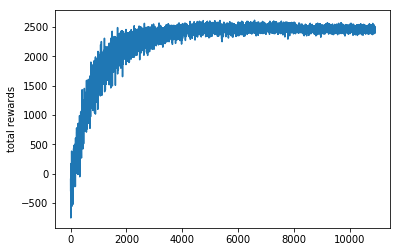

In [29]:
# Check Convergence by tracking total rewards per episode vs episode number
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.ylabel("total rewards")
plt.show()

In [30]:
# Average reward per 100 episode
avg_rewards = []
episodes = len(rewards_per_episode)
index = 0
track_total_reward = 0
for episode_number in range(episodes):
    if index != 100:
        track_total_reward += rewards_per_episode[episode_number]
        index += 1
    else:
        avg_rewards.append(track_total_reward/index)
        track_total_reward = rewards_per_episode[episode_number]
        index = 1

avg_rewards.append(track_total_reward/index)
        
    
print(avg_rewards)

[-106.36, 183.39, 406.2, 649.2, 913.84, 1063.14, 1238.96, 1406.92, 1546.54, 1601.1, 1749.89, 1806.04, 1856.21, 1903.09, 1969.32, 2027.01, 2069.19, 2101.7, 2155.73, 2180.62, 2204.34, 2220.0, 2263.02, 2268.31, 2306.46, 2306.41, 2333.99, 2317.94, 2337.81, 2355.75, 2356.99, 2384.27, 2383.63, 2377.69, 2400.43, 2411.45, 2413.87, 2424.04, 2434.75, 2428.77, 2446.57, 2460.82, 2454.04, 2454.36, 2461.55, 2466.47, 2469.95, 2465.05, 2473.92, 2469.47, 2475.51, 2476.98, 2487.9, 2468.97, 2457.36, 2477.46, 2471.7, 2476.76, 2466.03, 2452.28, 2478.03, 2478.55, 2472.8, 2483.8, 2486.27, 2489.85, 2470.68, 2479.27, 2476.89, 2471.91, 2487.91, 2484.36, 2472.22, 2480.25, 2481.56, 2480.36, 2486.25, 2478.57, 2487.19, 2485.39, 2484.14, 2472.19, 2468.56, 2453.99, 2469.97, 2461.46, 2465.45, 2463.28, 2465.59, 2466.36, 2467.45, 2464.66, 2473.24, 2465.33, 2458.36, 2463.2, 2475.66, 2462.7, 2466.12, 2461.26, 2473.27, 2458.95, 2456.96, 2472.96, 2462.08, 2464.11, 2468.62, 2468.8, 2458.27, 2456.75]


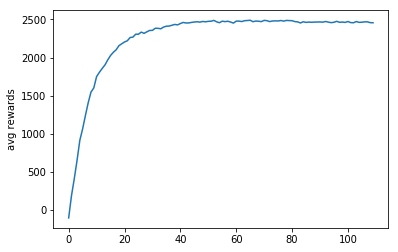

In [31]:
## Check Convergence by tracking average rewards per episode vs episode number
plt.plot(list(range(len(avg_rewards))), avg_rewards)
plt.ylabel("avg rewards")
plt.show()

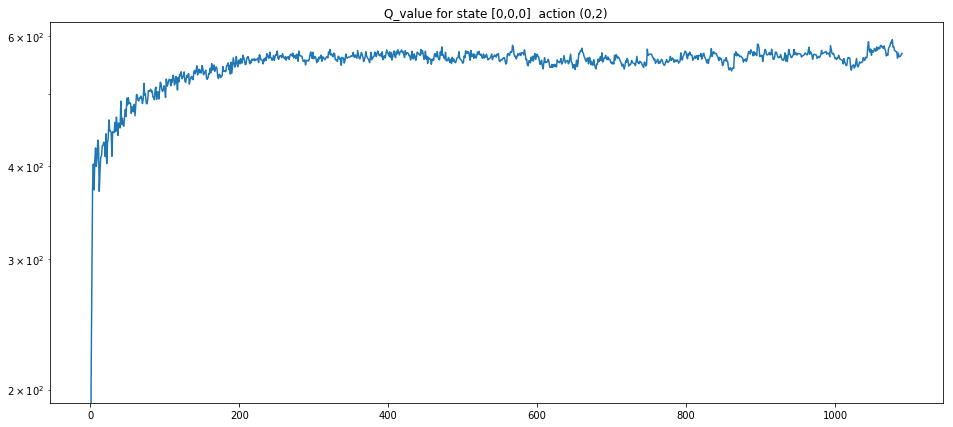

In [32]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [33]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

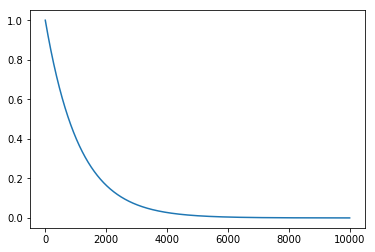

In [34]:
plt.plot(time, epsilon)
plt.show()